# Setup

## Imports

In [1]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

import torch
import torch.autograd.variable as Variable
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as utils
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from shutil import copyfile

# Preparing dataloaders

## **Raw data**



### Downloading data


We use the Adience dataset consisting unfiltered faces ([Link](http://www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/aligned.tar.gz)). Then, we unzip it.  
The first cell below downloads the data for you and places it in the **data** directory. The second cell unzips the data.

### Downloading folds

All five folds used in this paper are present [here](https://github.com/GilLevi/AgeGenderDeepLearning/tree/master/Folds/train_val_txt_files_per_fold). Download the **train_val_txt_files_per_fold** folder and place it in **My Drive/AgeGenderClassification/data**.


## Data loading

In [3]:
PATH_TO_FOLDS = "data/train_val_txt_files_per_fold"
PATH_TO_DATA = "data/"
PATH_TO_IMAGE_FOLDERS = PATH_TO_DATA + "aligned/"

In [4]:
# Notify me on completion by sound
from IPython.display import Audio
sound_file = '/root/beep-07a.wav'

#Audio(sound_file, autoplay=True)

### Creating a Dataset class

We create a class **`AdienceDataset`** that extends **`Dataset`**. This class helps us in feeding the input data to the network in minibatches.

[This](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) is a useful tutorial on how to load and augment data in PyTorch. 

In [5]:
class AdienceDataset(Dataset):
    
    def __init__(self, txt_file, root_dir, transform):
        self.txt_file = txt_file
        self.root_dir = root_dir
        self.transform = transform
        self.data = self.read_from_txt_file()
    
    def __len__(self):
        return len(self.data)

    def read_from_txt_file(self):
        data = []
        f = open(self.txt_file)
        for line in f.readlines():
            image_file, label = line.split() 
            label = int(label)
            if 'gender' in self.txt_file:
                label += 8
            data.append((image_file, label))
        return data
    
    def __getitem__(self, idx):
        img_name, label = self.data[idx]
        image = Image.open(self.root_dir + '/' + img_name)
        
        if self.transform:
            image = self.transform(image)
            
        return {
            'image': image,
            'label': label
        }
    
class AdienceDatasetCombined(Dataset):
    
    def __init__(self, txt_dir, subset, root_dir, transform):
        self.txt_dir = txt_dir
        self.subset = subset
        self.root_dir = root_dir
        self.transform = transform
        self.data = self.read_from_txt_file()
    
    def __len__(self):
        return len(self.data)

    def read_from_txt_file(self):
        data = []
        data2 = []
        age_txt_file = f'{self.txt_dir}/age_{self.subset}.txt'
        gender_txt_file = f'{self.txt_dir}/gender_{self.subset}.txt'
        age_file = open(age_txt_file)        
        for line in age_file.readlines():
            image_file, label = line.split() 
            label = int(label)
            data.append((image_file, label))
        age_file.close()
        gender_file = open(gender_txt_file)
        for line in gender_file.readlines():
            image_file, label = line.split() 
            label = int(label)
            for record in data:
                if (record[0] == image_file):
                    data2.append((image_file, record[1] + 10*label))
                    break
        return data2
    
    def __getitem__(self, idx):
        img_name, label = self.data[idx]
        image = Image.open(self.root_dir + '/' + img_name)
        
        if self.transform:
            image = self.transform(image)
            
        return {
            'image': image,
            'label': label
        }

### Transforms
Every image is first resized to a `256x256` image and then cropped to a `227x227` image before being fed to the network.

**`transforms_list`** is the list of transforms we would like to apply to the input data. Apart from training the neural network without any transformations, we can also train the network using the following transforms (also called as data augmentation techniques):
*   random horizontal flip
*   random crop and random horizontal flip

We don't perform any transformation on the images during validation and testing.


In [6]:
transforms_list = [
    transforms.Resize(256), # 0 (required)
    transforms.CenterCrop(227), #1 (required)
    transforms.RandomHorizontalFlip(), #2
    transforms.ToTensor(), #3 (required)
    transforms.RandomCrop(227) #4
]

# Adversarial training
# Look into increase or decrease contrast
# Look into principal component analysis (PCA) on the RGB colourspace

# Pre-training using the CelebA dataset http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html
# Essentially, meaning getting parameters but not calculating accuracy

transforms_dict = {
    'train': {
        0: list(transforms_list[i] for i in [0, 1, 3]),        # no transformation
        1: list(transforms_list[i] for i in [0, 1, 2, 3]),     # random horizontal flip
        2: list(transforms_list[i] for i in [0, 4, 2, 3])      # random crop and random horizontal flip
    },
    'val': {
        0: list(transforms_list[i] for i in [0, 1, 3])
    },
    'test': {
        0: list(transforms_list[i] for i in [0, 1, 3])
    }
}

### Dataloader
The **`DataLoader`** class in PyTorch helps us iterate through the dataset. This is where we input **`minibatch_size`** to our algorithm.

In [7]:
def get_dataloader(s, c, fold, transform_index, minibatch_size):
    """
    Args:
        s: A string. Equals either "train", "val", or "test".
        c: A string. Equals either "age" or "gender", or 'both'
        fold: An integer. Lies in the range [0, 4] as there are five folds present.
        transform_index: An integer. The transforms in the list correesponding
            to this index in the dictionary will be applied on the images.
        minibatch_size: An integer.

    Returns:
        An instance of the DataLoader class.
    """
    root_dir = PATH_TO_IMAGE_FOLDERS
    if c == "both":
        txt_file = f'{PATH_TO_FOLDS}/test_fold_is_{fold}'
        transformed_dataset = AdienceDatasetCombined(txt_file, s, root_dir,
                                         transforms.Compose(transforms_dict[s][transform_index]))
        dataloader = DataLoader(transformed_dataset, batch_size=minibatch_size, shuffle=True, num_workers=24)
        return dataloader
    else:
        txt_file = f'{PATH_TO_FOLDS}/test_fold_is_{fold}/{c}_{s}.txt'        
        transformed_dataset = AdienceDataset(txt_file, root_dir,
                                         transforms.Compose(transforms_dict[s][transform_index]))
        dataloader = DataLoader(transformed_dataset, batch_size=minibatch_size, shuffle=True, num_workers=24)
        return dataloader    

# Network

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [9]:
PATH_TO_MODELS = "models_alexnet"

## Defining the network
This is the network as described in the [paper](https://talhassner.github.io/home/projects/cnn_agegender/CVPR2015_CNN_AgeGenderEstimation.pdf).

In [10]:
# Using AlexNet, but replacing the last layer

class SlimNet(nn.Module):
    
    def __init__(self):
        super(SlimNet, self).__init__()  
        self.fc3 = nn.Linear(4096, 18)
    
        self.apply(weights_init)    
        
    def forward(self, x):
      
        x = F.log_softmax(self.fc3(x), dim=1)
  
        return x

def NewNet():
    new_net = models.alexnet()
    new_net.classifier[6] = nn.Identity()
    model = nn.Sequential(new_net, SlimNet())
    return model

def Net():
    return NewNet()

In [11]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0, std=1e-2)

In [12]:
criterion = nn.NLLLoss()

## Hyperparameters
Try playing with these! While the **`minibatch_size`** and **`lr`** are pulled from the paper, **`num_epochs`** is set empirically. 

In [13]:
minibatch_size = 50
num_epochs = 200
lr = 0.0001  # initial learning rate

## Training the network
We save the network to the drive and compute the loss on validation set after every **`checkpoint_frequency`** number of iterations. We decrease the learning by a tenth after 10,000 iterations using the **`MultiStepLR`** class of PyTorch.

In [14]:
def train(net, train_dataloader, epochs, filename, checkpoint_frequency=50, val_dataloader=None, patience=None):
    """
    Args:
        net: An instance of PyTorch's Net class.
        train_dataloader: An instance of PyTorch's Dataloader class.
        epochs: An integer.
        filename: A string. Name of the model saved to drive.
        checkpoint_frequency: An integer. Represents how frequent (in terms
            of number of iterations) the model should be saved to drive.
        val_dataloader: An instance of PyTorch's Dataloader class.
    
    Returns:
        net: An instance of PyTorch's Net class. The trained network.
        training_loss: A list of numbers that represents the training loss at each checkpoint.
        validation_loss: A list of numbers that represents the validation loss at each checkpoint.
    """
    net.train()
    optimizer = optim.Adam(net.parameters(), lr)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10000])
    
    training_loss, validation_loss = [], []
    checkpoint = 0
    iteration = 0
    running_loss = 0
    best_iteration = 1
    best_validation_loss = np.inf
    
    for epoch in range(epochs):
        
        for i, batch in enumerate(train_dataloader):
            scheduler.step()
            optimizer.zero_grad()
            images, labels = batch['image'].to(device), batch['label'].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            running_loss += float(loss.item())
            loss.backward()
            optimizer.step()
            
            if (iteration+1) % checkpoint_frequency == 0 and val_dataloader is not None:
                if patience == None:
                    training_loss.append(running_loss/checkpoint_frequency)
                    validation_loss.append(validate(net, val_dataloader))
                    print(f'minibatch:{i}, epoch:{epoch+1}, iteration:{iteration}, training_error:{training_loss_result}, validation_error:{validation_loss_result}')
                    save_network(net, f'{filename}_checkpoint{checkpoint}')                        
                elif patience > 0:
                    training_loss_result = running_loss/checkpoint_frequency
                    validation_loss_result = validate(net, val_dataloader)
                    print(f'minibatch:{i}, epoch:{epoch+1}, iteration:{iteration}, training_error:{training_loss_result}, validation_error:{validation_loss_result}')
                    if best_validation_loss >= validation_loss_result:
                        print(f'Best loss improvement from {best_validation_loss} to {validation_loss_result} in epoch {epoch+1}')
                        best_validation_loss = validation_loss_result
                        best_epoch = epoch + 1
                        training_loss.append(training_loss_result)
                        validation_loss.append(validation_loss_result)
                        save_network(net, f'{filename}_checkpoint{checkpoint}')
                        best_iteration = iteration + 1
                    elif best_iteration + patience * checkpoint_frequency <= iteration:
                        print(f"Patience ran out at {iteration}. Ending training")
                        return net, training_loss, validation_loss
                    else:
                        training_loss.append(training_loss_result)
                        validation_loss.append(validation_loss_result)
                checkpoint += 1
                running_loss = 0
            iteration += 1

    return net, training_loss, validation_loss

## Validation
We evaluate the performance (in terms of loss) of the trained network on validation set.

In [15]:
def validate(net, dataloader):
    net.train()
    total_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            images, labels = batch['image'].to(device), batch['label'].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            total_loss += float(loss.item())

    return total_loss/(i+1)

In [16]:
def get_validation_error(c, fold, train_transform_index):
    filename = get_model_filename(c, fold, train_transform_index)
    net = Net().to(device)
    net.load_state_dict(torch.load(f'{PATH_TO_MODELS}/{filename}'))
    return validate(net, get_dataloader('val', c, fold, 0, minibatch_size))

## Testing
We evaluate the performance (in terms of accuracy) of the trained network on the test set.

In [17]:
def test(net, dataloader, c):
    result = {
        'exact_match': 0,
        'total': 0
    }
    if c != 'gender':
        result['one_off_match'] = 0
    if c == 'both':
        result['gender_match'] = 0
        result['age_match'] = 0
        result['one_off_age_match'] = 0

    with torch.no_grad():
        net.eval()
        for i, batch in enumerate(dataloader):
            images, labels = batch['image'].to(device), batch['label'].to(device)
            outputs = net(images)
            outputs = torch.tensor(list(map(lambda x: torch.max(x, 0)[1], outputs))).to(device)
            result['total'] += len(outputs)
            result['exact_match'] += sum(outputs == labels).item()
            if c != 'gender':
                result['one_off_match'] += (sum(outputs==labels) +
                                            sum(outputs==labels-1) +
                                            sum(outputs==labels+1)).item()
            if c == 'both':
                for count, o in enumerate(outputs):
                    o = o.item()
                    if o <= 7: # male
                        if labels[count].item() >= 0 and labels[count].item() <= 7:
                            result['gender_match'] += 1
                        if labels[count].item() == o or labels[count].item() == o + 7:
                            result['age_match'] += 1
                            result['one_off_age_match'] += 1
                        if labels[count].item() == o + 1 or labels[count].item() == o - 1 \
                        or labels[count].item() == o + 8 or labels[count].item() == o + 6:
                            result['one_off_age_match'] += 1
                    elif o >= 10: # female
                        if labels[count].item() >= 10:
                            result['gender_match'] += 1
                        if labels[count].item() == o or labels[count].item() == o - 7:
                            result['age_match'] += 1
                            result['one_off_age_match'] += 1
                        if labels[count].item() == o + 1 or labels[count].item() == o - 1 \
                        or labels[count].item() == o - 8 or labels[count].item() == o - 6:
                            result['one_off_age_match'] += 1

    return result           

## Saving the network

In [18]:
def save_network(net, filename):
    torch.save(net.state_dict(), f'{PATH_TO_MODELS}/{filename}.pt')

# Execution

### Picking the best model for a fold
**`train_save()`** trains the network using the **`train()`** function and then, using the validation losses returned by this function at all checkpoints, chooses the model with least validation error. This function also plots a graph of training and validation errors over the iterations.

**Usage:**

For e.g., if you want to train the network for **`age`** using **`fold=2`** and **`train_transform_index=2`**,
```
train_save('age', 2, 2)
```



In [19]:
def train_save(c, fold, train_transform_index, checkpoint_frequency=50, patience=10):
    """
    Args:
        c: A string. Equals either "age" or "gender".
        fold: An integer. Lies in the range [0, 4] as there are five folds present.
        train_transform_index: An integer. The transforms in the list correesponding
            to this index in the dictionary will be applied on the images.
        checkpoint_frequency: An integer. Represents how frequent (in terms
            of number of iterations) the model should be saved to drive.   
    Returns:
        validation_loss: A list of numbers that represents the validation loss at each checkpoint.
    """
    if c != "both":
        trained_net, training_loss, validation_loss = train(
            Net().to(device),
            get_dataloader('train', c, fold, train_transform_index, minibatch_size),
            num_epochs,
            f'{fold}_{c}_train_{train_transform_index}',
            checkpoint_frequency,
            get_dataloader('val', c, fold, 0, minibatch_size),
            patience=patience
        )

        plt.plot(list(range(1, len(validation_loss)+1)), validation_loss, label='validation_loss')
        plt.plot(list(range(1, len(training_loss)+1)), training_loss, label='training_loss')
        plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=2, mode="expand", borderaxespad=0.)
        plt.xlabel('iterations')
        plt.ylabel('loss')
        plt.show()

        choose_model_with_least_val_error(c, fold, train_transform_index, validation_loss)

        return validation_loss
    else:
        trained_net, training_loss, validation_loss = train(
            NewNet().to(device),
            get_dataloader('train', c, fold, train_transform_index, minibatch_size),
            num_epochs,
            f'{fold}_{c}_train_{train_transform_index}',
            checkpoint_frequency,
            get_dataloader('val', c, fold, 0, minibatch_size),
            patience=patience
        )

        plt.plot(list(range(1, len(validation_loss)+1)), validation_loss, label='validation_loss')
        plt.plot(list(range(1, len(training_loss)+1)), training_loss, label='training_loss')
        plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=2, mode="expand", borderaxespad=0.)
        plt.xlabel('iterations')
        plt.ylabel('loss')
        plt.show()

        choose_model_with_least_val_error(c, fold, train_transform_index, validation_loss)

        return validation_loss

In [20]:
def choose_model_with_least_val_error(c, fold, train_transform_index, validation_loss):
    index = validation_loss.index(min(validation_loss))
    filename = f'{fold}_{c}_train_{train_transform_index}'
    for file in os.listdir(PATH_TO_MODELS):
        if file.startswith(filename):
            if file.startswith(f'{filename}_checkpoint{index}'):
                pass
            else:
                os.remove(f'{PATH_TO_MODELS}/{file}')

### Picking the best model among all the folds

Using **`pick_best_model()`**, we can pick the model among various folds that gives us the best validation accuracy. The best model's name is appended with **_best **in the **models** directory. 

**Usage:**

To pick the best model for **`age`**,
```
pick_best_model('age')
```


To pick the best model for **`gender`**,

```
pick_best_model('gender')
```

In [21]:
def pick_best_model(c):
    """
    Args:
        s: A string. Equals either "train", "val", or "test".
        c: A string. Equals either "age", "gender" or "both".
    """
    def fn_filter(file):
        file_split = file.split('_')
        return True if (len(file_split) == 5 and file_split[1] == c) else False
    
    def fn_map(file):
        file_split = file.split('_')
        return get_validation_error(c, file_split[0], file_split[3])
    
    files = list(filter(fn_filter, os.listdir(PATH_TO_MODELS)))
    val_errors = list(map(fn_map, files))
    min_val_error, file = min(zip(val_errors, files))
    best_model = f'{PATH_TO_MODELS}/{file.split(".")[0]}_best.pt'
    copyfile(f'{PATH_TO_MODELS}/{file}', best_model)
    
    print(f'Picking {best_model} as the best model for {c}...')

### Calculating performance/accuracy

We can check the performance of any model using the **`get_performance()`** function.

**Usage:**

To know the performance on **`age`** classification,
```
get_performance('age')
```


To know the performance on **`gender`** classification,

```
get_performance('gender')
```



In [22]:
def get_performance(c):
    """
    Args:
        c: A string. Equals either "age" or "gender".
    Returns:
        A dictionary containing accuracy (and one-off accuracy for age) of the model.
    """    
    file = get_best_model_filename(c).split('_')
    return get_performance_of_a_model('test', file[1], file[0], file[3])

In [23]:
def get_best_model_filename(c):
    def fn_filter(file):
        file_split = file.split('_')
        return True if (len(file_split) == 6 and file_split[1] == c) else False
    
    return list(filter(fn_filter, os.listdir(PATH_TO_MODELS)))[0]

In [24]:
def get_performance_of_a_model(s, c, fold, train_transform_index):
    """
    Args:
        s: A string. Equals either "train", "val", or "test".
        c: A string. Equals either "age" or "gender".
        fold: An integer. Lies in the range [0, 4] as there are five folds present.
        transform_index: An integer. The transforms in the list correesponding
            to this index in the dictionary will be applied on the images.
    Returns:
        A dictionary containing accuracy (and one-off accuracy for age) of the model.
    """
    filename = get_model_filename(c, fold, train_transform_index)
    if c != "both":
        net = Net().to(device)
        net.load_state_dict(torch.load(f'{PATH_TO_MODELS}/{filename}'))
        performance = test(
            net,
            get_dataloader(s, c, fold, 0, minibatch_size),
            c
        )
        if c != 'gender':
            return {
                'accuracy': performance['exact_match']/performance['total'],
                'one-off accuracy': performance['one_off_match']/performance['total']
            }
        else:
            return {
                'accuracy': performance['exact_match']/performance['total']
            }
    else:
        net = NewNet().to(device)
        net.load_state_dict(torch.load(f'{PATH_TO_MODELS}/{filename}'))
        performance = test(
            net,
            get_dataloader(s, c, fold, 0, minibatch_size),
            c
        )
        return {
            'accuracy': performance['exact_match']/performance['total'],
            'one-off accuracy': performance['one_off_match']/performance['total'],
            'gender accuracy': performance['gender_match']/performance['total'],
            'age accuracy': performance['age_match']/performance['total'],
            'one-off age accuracy': performance['one_off_age_match']/performance['total']
        }

In [25]:
def get_model_filename(c, fold, train_transform_index):
    start_of_filename = f'{fold}_{c}_train_{train_transform_index}_checkpoint'
    for file in os.listdir(PATH_TO_MODELS):
        if file.startswith(start_of_filename):
            return file

In [26]:
print(NewNet())

Sequential(
  (0): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False)
      (1):

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


minibatch:49, epoch:1, iteration:49, training_error:2.7129912185668945, validation_error:2.658133586247762
Best loss improvement from inf to 2.658133586247762 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.6568046951293947, validation_error:2.6416945358117423
Best loss improvement from 2.658133586247762 to 2.6416945358117423 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.621837682723999, validation_error:2.631997207800547
Best loss improvement from 2.6416945358117423 to 2.631997207800547 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.6005891132354737, validation_error:2.5269069373607635
Best loss improvement from 2.631997207800547 to 2.5269069373607635 in epoch 1
minibatch:25, epoch:2, iteration:249, training_error:2.5324692153930664, validation_error:2.4954963425795236
Best loss improvement from 2.5269069373607635 to 2.4954963425795236 in epoch 2
minibatch:75, epoch:2, iteration:299, training_error:2.4596736431121826, validatio

minibatch:111, epoch:13, iteration:2799, training_error:0.6478436410427093, validation_error:1.255523070693016
minibatch:161, epoch:13, iteration:2849, training_error:0.6500833690166473, validation_error:1.227088523407777
minibatch:211, epoch:13, iteration:2899, training_error:0.6684181499481201, validation_error:1.2244842151800792
minibatch:37, epoch:14, iteration:2949, training_error:0.5611469715833663, validation_error:1.3023726418614388
minibatch:87, epoch:14, iteration:2999, training_error:0.5515002143383027, validation_error:1.283313438296318
minibatch:137, epoch:14, iteration:3049, training_error:0.5593733221292496, validation_error:1.3831104437510173
minibatch:187, epoch:14, iteration:3099, training_error:0.6042768412828445, validation_error:1.338182603319486
minibatch:13, epoch:15, iteration:3149, training_error:0.5732344281673432, validation_error:1.3121741190552711
Patience ran out at 3149. Ending training


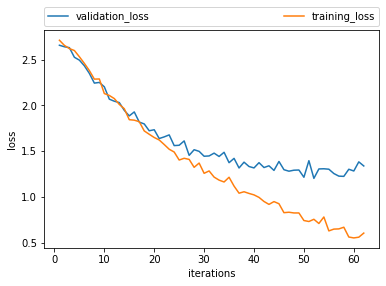

[2.658133586247762,
 2.6416945358117423,
 2.631997207800547,
 2.5269069373607635,
 2.4954963425795236,
 2.433515946070353,
 2.3506126503149667,
 2.2443582812945047,
 2.2517303625742593,
 2.203756590684255,
 2.0687408596277237,
 2.046271115541458,
 2.031423653165499,
 1.9465162456035614,
 1.8858249535163243,
 1.9291457831859589,
 1.8181655605634053,
 1.7977847456932068,
 1.7231641511122386,
 1.7343026498953502,
 1.6382657239834468,
 1.656196415424347,
 1.6781016786893208,
 1.560952251156171,
 1.5646521399418514,
 1.61214812596639,
 1.4544210930665333,
 1.5158298661311467,
 1.4981038570404053,
 1.4445325533548992,
 1.4478869313995044,
 1.4784974455833435,
 1.4419720023870468,
 1.4877163370450337,
 1.3742505759000778,
 1.4212740908066432,
 1.3161630084117253,
 1.3798871462543805,
 1.3322722911834717,
 1.3169251928726833,
 1.3743722538153331,
 1.321147307753563,
 1.3401691317558289,
 1.2897012208898861,
 1.3875143453478813,
 1.2974689279993374,
 1.2811546549201012,
 1.2919909358024597,
 1.

In [27]:
train_save('both', 0, 0, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:2.6585474157333375, validation_error:2.6322110493977866
Best loss improvement from inf to 2.6322110493977866 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.5987661933898925, validation_error:2.612966714081941
Best loss improvement from 2.6322110493977866 to 2.612966714081941 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.614549493789673, validation_error:2.609688299673575
Best loss improvement from 2.612966714081941 to 2.609688299673575 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.5794677925109863, validation_error:2.542133172353109
Best loss improvement from 2.609688299673575 to 2.542133172353109 in epoch 1
minibatch:10, epoch:2, iteration:249, training_error:2.5079956579208376, validation_error:2.461764106044063
Best loss improvement from 2.542133172353109 to 2.461764106044063 in epoch 2
minibatch:60, epoch:2, iteration:299, training_error:2.3311430978775025, validation_err

minibatch:159, epoch:11, iteration:2549, training_error:0.8409598124027252, validation_error:1.2522165068873652
minibatch:209, epoch:11, iteration:2599, training_error:0.8361811876296997, validation_error:1.2532368456875835
minibatch:20, epoch:12, iteration:2649, training_error:0.785421291589737, validation_error:1.2251284696437694
minibatch:70, epoch:12, iteration:2699, training_error:0.7624120110273361, validation_error:1.2400874738340024
minibatch:120, epoch:12, iteration:2749, training_error:0.7271912467479705, validation_error:1.1819837799778692
Best loss improvement from 1.1899310968540333 to 1.1819837799778692 in epoch 12
minibatch:170, epoch:12, iteration:2799, training_error:0.7384034788608551, validation_error:1.2114664868072227
minibatch:220, epoch:12, iteration:2849, training_error:0.774685885310173, validation_error:1.2684651458704914
minibatch:31, epoch:13, iteration:2899, training_error:0.6656429225206375, validation_error:1.2223975172749273
minibatch:81, epoch:13, itera

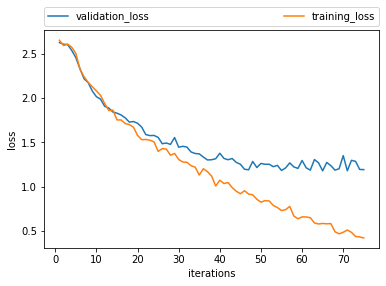

[2.6322110493977866,
 2.612966714081941,
 2.609688299673575,
 2.542133172353109,
 2.461764106044063,
 2.3340687486860485,
 2.221469905641344,
 2.1774248061356722,
 2.0824396786866366,
 2.0181704229778714,
 1.9908612304263644,
 1.9097149637010362,
 1.890168269475301,
 1.8448266144152041,
 1.8317748175726996,
 1.8115419502611514,
 1.7784591692465324,
 1.7303683581175628,
 1.7371211184395685,
 1.7175941467285156,
 1.6742387745115492,
 1.5889735530923914,
 1.5775828493965998,
 1.5793528512672141,
 1.5576587518056233,
 1.4856480934001781,
 1.4933016697565715,
 1.4778862750088726,
 1.5559499219611839,
 1.445606611393116,
 1.4562322740201596,
 1.4476209569860388,
 1.3922074856581512,
 1.3745905734874584,
 1.3706476776688188,
 1.3339853706183258,
 1.3014920662950586,
 1.3038621522762157,
 1.3156027793884277,
 1.3777343100971646,
 1.3188917990084048,
 1.3039243905632585,
 1.31808438345238,
 1.2737800059495148,
 1.252983848253886,
 1.1960912523446259,
 1.1899310968540333,
 1.2845481369230483,
 1

In [28]:
train_save('both', 1, 0, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:2.6451534032821655, validation_error:2.610562801361084
Best loss improvement from inf to 2.610562801361084 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.6073950004577635, validation_error:2.5952888506430165
Best loss improvement from 2.610562801361084 to 2.5952888506430165 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.599799146652222, validation_error:2.585591784229985
Best loss improvement from 2.5952888506430165 to 2.585591784229985 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.5620367908477784, validation_error:2.525593395586367
Best loss improvement from 2.585591784229985 to 2.525593395586367 in epoch 1
minibatch:12, epoch:2, iteration:249, training_error:2.4729658555984497, validation_error:2.513378390559444
Best loss improvement from 2.525593395586367 to 2.513378390559444 in epoch 2
minibatch:62, epoch:2, iteration:299, training_error:2.375285167694092, validation_erro

minibatch:192, epoch:12, iteration:2799, training_error:0.7904979366064072, validation_error:1.2831201398814167
minibatch:5, epoch:13, iteration:2849, training_error:0.7555733126401901, validation_error:1.2102724644872878
Best loss improvement from 1.2704221782860932 to 1.2102724644872878 in epoch 13
minibatch:55, epoch:13, iteration:2899, training_error:0.6749477130174637, validation_error:1.3341336382759943
minibatch:105, epoch:13, iteration:2949, training_error:0.6650314074754715, validation_error:1.3160308731926813
minibatch:155, epoch:13, iteration:2999, training_error:0.6773558211326599, validation_error:1.2338772813479106
minibatch:205, epoch:13, iteration:3049, training_error:0.6621088802814483, validation_error:1.3360628441528037
minibatch:18, epoch:14, iteration:3099, training_error:0.6200195282697678, validation_error:1.3333076658072296
minibatch:68, epoch:14, iteration:3149, training_error:0.5847337746620178, validation_error:1.241475067756794
minibatch:118, epoch:14, itera

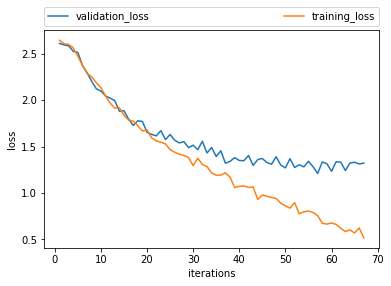

[2.610562801361084,
 2.5952888506430165,
 2.585591784229985,
 2.525593395586367,
 2.513378390559444,
 2.3735035260518393,
 2.2950211542624013,
 2.2026866409513683,
 2.122299000068947,
 2.0982880239133483,
 2.0450331811551696,
 2.022141116636771,
 1.9942061636182997,
 1.8809852865007188,
 1.88539222434715,
 1.7955113075397633,
 1.7281850134884869,
 1.778281706350821,
 1.7707263628641765,
 1.6544116470548842,
 1.6316637286433466,
 1.615121567690814,
 1.6713291494934648,
 1.5751104553540547,
 1.62998068774188,
 1.5678168755990487,
 1.539821743965149,
 1.5526814063390095,
 1.48856281792676,
 1.5148950506139685,
 1.466822376957646,
 1.5567658124146637,
 1.4313515822092693,
 1.4899238701219912,
 1.3935656635849565,
 1.4546669942361337,
 1.320269712695369,
 1.3408955159010711,
 1.3803863481239036,
 1.3504208812007197,
 1.347678087375782,
 1.4039034534383703,
 1.2972610438311543,
 1.3593402394541987,
 1.372060998722359,
 1.327056803085186,
 1.310653668862802,
 1.3903614150153265,
 1.3006766747

In [29]:
train_save('both', 2, 0, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:2.7075288438797, validation_error:2.626335276497735
Best loss improvement from inf to 2.626335276497735 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.6409458112716675, validation_error:2.6209669996190956
Best loss improvement from 2.626335276497735 to 2.6209669996190956 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.621384735107422, validation_error:2.6133243949324996
Best loss improvement from 2.6209669996190956 to 2.6133243949324996 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.611093144416809, validation_error:2.559146139356825
Best loss improvement from 2.6133243949324996 to 2.559146139356825 in epoch 1
minibatch:8, epoch:2, iteration:249, training_error:2.5595958042144775, validation_error:2.488626797993978
Best loss improvement from 2.559146139356825 to 2.488626797993978 in epoch 2
minibatch:58, epoch:2, iteration:299, training_error:2.4871258211135863, validation_error

minibatch:139, epoch:11, iteration:2549, training_error:0.8610397565364838, validation_error:1.3282837911888405
minibatch:189, epoch:11, iteration:2599, training_error:0.8466467869281769, validation_error:1.3101770436322246
minibatch:239, epoch:11, iteration:2649, training_error:0.9101939630508423, validation_error:1.3232601284980774
minibatch:48, epoch:12, iteration:2699, training_error:0.7581346106529235, validation_error:1.3686124881108601
minibatch:98, epoch:12, iteration:2749, training_error:0.8133434927463532, validation_error:1.304082210417147
minibatch:148, epoch:12, iteration:2799, training_error:0.7750760334730148, validation_error:1.3062333133485582
minibatch:198, epoch:12, iteration:2849, training_error:0.7899966764450074, validation_error:1.2614871351807206
Best loss improvement from 1.288834086170903 to 1.2614871351807206 in epoch 12
minibatch:7, epoch:13, iteration:2899, training_error:0.7645847535133362, validation_error:1.3236996995078192
minibatch:57, epoch:13, iterat

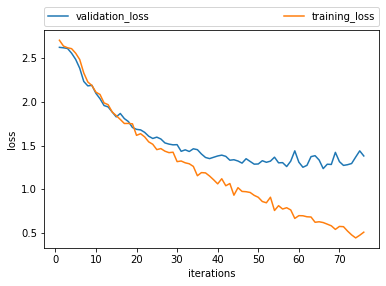

[2.626335276497735,
 2.6209669996190956,
 2.6133243949324996,
 2.559146139356825,
 2.488626797993978,
 2.387428080594098,
 2.235756935896697,
 2.1848772543447987,
 2.1917895211113825,
 2.0996174856468484,
 2.037996561438949,
 1.9599439567989774,
 1.9442002375920613,
 1.8860286341773138,
 1.8300146968276412,
 1.8689798602351435,
 1.8103911523465757,
 1.7764640693311338,
 1.7083399339958474,
 1.6873670463208799,
 1.6812744714595653,
 1.6530567760820742,
 1.6086416597719546,
 1.5830196230499833,
 1.5980203946431477,
 1.5769197057794642,
 1.531923528070803,
 1.5183788493827537,
 1.5100559702625982,
 1.5121876177964386,
 1.4358472250126026,
 1.4528015984429254,
 1.4339507244251393,
 1.4647516586162426,
 1.454728400265729,
 1.4048293056311432,
 1.3653847420657124,
 1.352376487520006,
 1.3676109313964844,
 1.3825481379473652,
 1.3921576031932124,
 1.3781088414015594,
 1.3339941060101543,
 1.3395560405872486,
 1.324786177387944,
 1.3006970396748296,
 1.3510933496333934,
 1.3197222065042566,
 1

In [30]:
train_save('both', 3, 0, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:2.6570846796035767, validation_error:2.652675151824951
Best loss improvement from inf to 2.652675151824951 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.612705135345459, validation_error:2.6105943276331973
Best loss improvement from 2.652675151824951 to 2.6105943276331973 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.590828523635864, validation_error:2.537936045573308
Best loss improvement from 2.6105943276331973 to 2.537936045573308 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.5337450981140135, validation_error:2.4299496779075036
Best loss improvement from 2.537936045573308 to 2.4299496779075036 in epoch 1
minibatch:17, epoch:2, iteration:249, training_error:2.365799489021301, validation_error:2.3228972233258762
Best loss improvement from 2.4299496779075036 to 2.3228972233258762 in epoch 2
minibatch:67, epoch:2, iteration:299, training_error:2.304425678253174, validation_e

minibatch:229, epoch:11, iteration:2549, training_error:0.8061013913154602, validation_error:1.1830421869571393
minibatch:47, epoch:12, iteration:2599, training_error:0.7289574676752091, validation_error:1.1327556990660155
minibatch:97, epoch:12, iteration:2649, training_error:0.7079662835597992, validation_error:1.1085391319715059
minibatch:147, epoch:12, iteration:2699, training_error:0.6919008147716522, validation_error:1.0835124139602368
Best loss improvement from 1.1048647990593543 to 1.0835124139602368 in epoch 12
minibatch:197, epoch:12, iteration:2749, training_error:0.7068427056074142, validation_error:1.075380428479268
Best loss improvement from 1.0835124139602368 to 1.075380428479268 in epoch 12
minibatch:15, epoch:13, iteration:2799, training_error:0.6673961424827576, validation_error:1.1032654069937193
minibatch:65, epoch:13, iteration:2849, training_error:0.5564776945114136, validation_error:1.143050035605064
minibatch:115, epoch:13, iteration:2899, training_error:0.57696

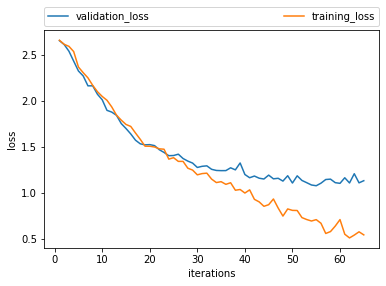

[2.652675151824951,
 2.6105943276331973,
 2.537936045573308,
 2.4299496779075036,
 2.3228972233258762,
 2.2689994115095873,
 2.1614081538640537,
 2.161774543615488,
 2.0697142481803894,
 2.009792923927307,
 1.8949113671596234,
 1.876042535671821,
 1.8410357053463275,
 1.7512174569643462,
 1.6975043966219976,
 1.6386515544011042,
 1.5702831745147705,
 1.5310473900574904,
 1.5197991637083201,
 1.5222736918009245,
 1.5115879682394175,
 1.4671012209011958,
 1.4371658105116625,
 1.4020077998821552,
 1.4038399412081792,
 1.4183554649353027,
 1.3711996582838206,
 1.3432912390965681,
 1.3218264029576228,
 1.2740872273078332,
 1.286572488454672,
 1.2915891408920288,
 1.253944082902028,
 1.2415982347268324,
 1.2395050479815557,
 1.23997412278102,
 1.2703684316231654,
 1.2478995827528148,
 1.322917979497176,
 1.1974828380804796,
 1.1623545220265021,
 1.1807652345070472,
 1.1572199716017797,
 1.1484735012054443,
 1.1907445673759167,
 1.15053240611003,
 1.1563670497674208,
 1.1258111183459942,
 1.1

In [31]:
train_save('both', 4, 0, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:2.705166220664978, validation_error:2.65350349744161
Best loss improvement from inf to 2.65350349744161 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.6560129737854004, validation_error:2.651365637779236
Best loss improvement from 2.65350349744161 to 2.651365637779236 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.6262373304367066, validation_error:2.624082605044047
Best loss improvement from 2.651365637779236 to 2.624082605044047 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.6031646585464476, validation_error:2.567404876152674
Best loss improvement from 2.624082605044047 to 2.567404876152674 in epoch 1
minibatch:25, epoch:2, iteration:249, training_error:2.5571868658065795, validation_error:2.482727438211441
Best loss improvement from 2.567404876152674 to 2.482727438211441 in epoch 2
minibatch:75, epoch:2, iteration:299, training_error:2.4394905090332033, validation_error:2.3

minibatch:85, epoch:12, iteration:2549, training_error:1.048530023097992, validation_error:1.3757366240024567
minibatch:135, epoch:12, iteration:2599, training_error:1.031164484024048, validation_error:1.3474469880263011
Best loss improvement from 1.3603985110918682 to 1.3474469880263011 in epoch 12
minibatch:185, epoch:12, iteration:2649, training_error:1.0074378859996795, validation_error:1.3489434470733006
minibatch:11, epoch:13, iteration:2699, training_error:0.9753296327590942, validation_error:1.332234929005305
Best loss improvement from 1.3474469880263011 to 1.332234929005305 in epoch 13
minibatch:61, epoch:13, iteration:2749, training_error:0.9377485585212707, validation_error:1.3194328745206196
Best loss improvement from 1.332234929005305 to 1.3194328745206196 in epoch 13
minibatch:111, epoch:13, iteration:2799, training_error:0.9544386923313141, validation_error:1.300096943974495
Best loss improvement from 1.3194328745206196 to 1.300096943974495 in epoch 13
minibatch:161, epo

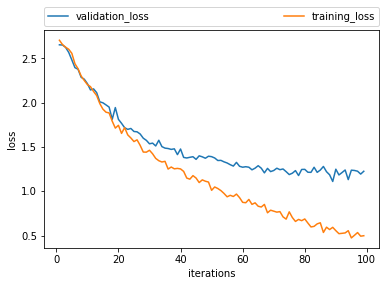

[2.65350349744161,
 2.651365637779236,
 2.624082605044047,
 2.567404876152674,
 2.482727438211441,
 2.395926515261332,
 2.3777477741241455,
 2.286525140206019,
 2.2654509941736856,
 2.2159378081560135,
 2.144126127163569,
 2.155751725037893,
 2.1132135887940726,
 2.009446715315183,
 1.9989703943332036,
 1.9751379042863846,
 1.9505513956149418,
 1.8121144821246464,
 1.9449928998947144,
 1.812190388639768,
 1.7672554552555084,
 1.7179074337085087,
 1.6986187746127446,
 1.7092300057411194,
 1.6750152955452602,
 1.6712884505589802,
 1.6467431584994,
 1.5992443561553955,
 1.5747850288947423,
 1.535980095465978,
 1.5435584684213002,
 1.5117397507031758,
 1.575822318593661,
 1.5041977713505428,
 1.4871717641750972,
 1.4826589226722717,
 1.4728863090276718,
 1.4792156368494034,
 1.4136607398589451,
 1.4770713398853939,
 1.3822385544578235,
 1.3758468826611836,
 1.383619174361229,
 1.3899835050106049,
 1.3603985110918682,
 1.4001928021510441,
 1.3888978709777196,
 1.372898429632187,
 1.39583021

In [32]:
train_save('both', 0, 1)

minibatch:49, epoch:1, iteration:49, training_error:2.6734694910049437, validation_error:2.6539725727505155
Best loss improvement from inf to 2.6539725727505155 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.606751546859741, validation_error:2.615885549121433
Best loss improvement from 2.6539725727505155 to 2.615885549121433 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.580446639060974, validation_error:2.5931448759856046
Best loss improvement from 2.615885549121433 to 2.5931448759856046 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.5473423290252684, validation_error:2.5379886009075023
Best loss improvement from 2.5931448759856046 to 2.5379886009075023 in epoch 1
minibatch:10, epoch:2, iteration:249, training_error:2.5209232234954833, validation_error:2.501091621540211
Best loss improvement from 2.5379886009075023 to 2.501091621540211 in epoch 2
minibatch:60, epoch:2, iteration:299, training_error:2.4290711164474486, validatio

minibatch:159, epoch:11, iteration:2549, training_error:1.0168139815330506, validation_error:1.2990631372840316
minibatch:209, epoch:11, iteration:2599, training_error:1.092524299621582, validation_error:1.2988336174576371
minibatch:20, epoch:12, iteration:2649, training_error:0.9895686006546021, validation_error:1.2191954564165186
Best loss improvement from 1.2429627489160608 to 1.2191954564165186 in epoch 12
minibatch:70, epoch:12, iteration:2699, training_error:0.9532122659683228, validation_error:1.1915384001202054
Best loss improvement from 1.2191954564165186 to 1.1915384001202054 in epoch 12
minibatch:120, epoch:12, iteration:2749, training_error:0.9541521918773651, validation_error:1.2573230376950018
minibatch:170, epoch:12, iteration:2799, training_error:0.9610924124717712, validation_error:1.2055852435253285
minibatch:220, epoch:12, iteration:2849, training_error:0.958942459821701, validation_error:1.26900303584558
minibatch:31, epoch:13, iteration:2899, training_error:0.95995

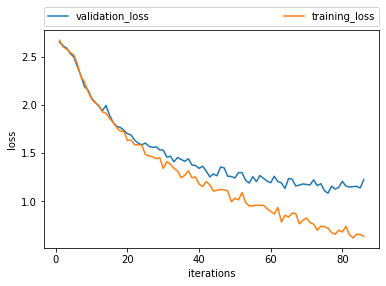

[2.6539725727505155,
 2.615885549121433,
 2.5931448759856046,
 2.5379886009075023,
 2.501091621540211,
 2.4021262416133173,
 2.3077931669023304,
 2.192196316189236,
 2.1558134290907116,
 2.0711939688082093,
 2.0300355664005987,
 1.987645732031928,
 1.9419406829056916,
 1.996528391484861,
 1.8944401299511944,
 1.8210589400044195,
 1.7790883514616225,
 1.7687188033704404,
 1.7384190382780853,
 1.7029316778536197,
 1.6903983575326424,
 1.6372017065684001,
 1.6043660640716553,
 1.58813300397661,
 1.6056463983323839,
 1.5724121773684467,
 1.5606303259178445,
 1.5675095496354279,
 1.535417742199368,
 1.5324002195287634,
 1.4606629036090992,
 1.468786734121817,
 1.4120891359117296,
 1.4564934836493597,
 1.4354587572592277,
 1.4157909287346735,
 1.4428532520929973,
 1.3793436642046328,
 1.3731617618490148,
 1.3430979560922693,
 1.3648918756732233,
 1.3158531255192227,
 1.2539491344381262,
 1.2851802971627977,
 1.2668226935245372,
 1.3568855656517878,
 1.3485856674335621,
 1.2617997151833993,
 

In [33]:
train_save('both', 1, 1)

minibatch:49, epoch:1, iteration:49, training_error:2.6686264276504517, validation_error:2.616940180460612
Best loss improvement from inf to 2.616940180460612 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.6203842687606813, validation_error:2.5880448288387723
Best loss improvement from 2.616940180460612 to 2.5880448288387723 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.578870439529419, validation_error:2.5661351680755615
Best loss improvement from 2.5880448288387723 to 2.5661351680755615 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.548013310432434, validation_error:2.5325821152439825
Best loss improvement from 2.5661351680755615 to 2.5325821152439825 in epoch 1
minibatch:12, epoch:2, iteration:249, training_error:2.50692617893219, validation_error:2.4089386728074818
Best loss improvement from 2.5325821152439825 to 2.4089386728074818 in epoch 2
minibatch:62, epoch:2, iteration:299, training_error:2.415494360923767, validation

minibatch:42, epoch:12, iteration:2649, training_error:1.0416654992103576, validation_error:1.2452655500835843
minibatch:92, epoch:12, iteration:2699, training_error:1.068996877670288, validation_error:1.2370772891574435
Best loss improvement from 1.2432844837506611 to 1.2370772891574435 in epoch 12
minibatch:142, epoch:12, iteration:2749, training_error:1.0190059995651246, validation_error:1.2076715341320745
Best loss improvement from 1.2370772891574435 to 1.2076715341320745 in epoch 12
minibatch:192, epoch:12, iteration:2799, training_error:1.0554927134513854, validation_error:1.290541942472811
minibatch:5, epoch:13, iteration:2849, training_error:1.0005204904079437, validation_error:1.222916932017715
minibatch:55, epoch:13, iteration:2899, training_error:0.9435488319396973, validation_error:1.2522031399938796
minibatch:105, epoch:13, iteration:2949, training_error:1.0044073069095611, validation_error:1.2533713954466361
minibatch:155, epoch:13, iteration:2999, training_error:0.992486

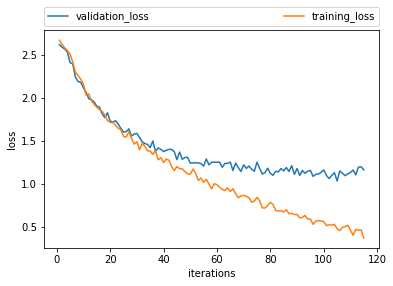

[2.616940180460612,
 2.5880448288387723,
 2.5661351680755615,
 2.5325821152439825,
 2.4089386728074818,
 2.3943673769632974,
 2.2393652024092496,
 2.189415874304595,
 2.180502185115108,
 2.115104463365343,
 2.065476832566438,
 1.989518889674434,
 1.979219463136461,
 1.9528057751832184,
 1.9035038462391607,
 1.8931846265439634,
 1.8142770970309223,
 1.7713106782348067,
 1.8269214188611065,
 1.7324540306020666,
 1.7161023484336004,
 1.7357008059819539,
 1.6961916111133717,
 1.6460105843014188,
 1.6036490069495306,
 1.6079068183898926,
 1.6403987495987504,
 1.5567132146270186,
 1.5799817597424541,
 1.5867482865298237,
 1.541068430300112,
 1.4911000242939703,
 1.4695145730619077,
 1.4596133673632588,
 1.4233733371452049,
 1.5001176374929923,
 1.3772403686134904,
 1.4192096127404108,
 1.4023355929939836,
 1.3774447220343131,
 1.3903131396682173,
 1.402227176560296,
 1.402137522344236,
 1.3763151853172868,
 1.283611253455833,
 1.3708519273334079,
 1.2872376574410334,
 1.307526809197885,
 1.3

In [34]:
train_save('both', 2, 1)

minibatch:49, epoch:1, iteration:49, training_error:2.678565583229065, validation_error:2.616760845537539
Best loss improvement from inf to 2.616760845537539 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.6397547245025637, validation_error:2.6302041389324047
minibatch:149, epoch:1, iteration:149, training_error:2.645016617774963, validation_error:2.5986003434216536
Best loss improvement from 2.616760845537539 to 2.5986003434216536 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.6032717514038084, validation_error:2.585697809855143
Best loss improvement from 2.5986003434216536 to 2.585697809855143 in epoch 1
minibatch:8, epoch:2, iteration:249, training_error:2.576898717880249, validation_error:2.5143846847392894
Best loss improvement from 2.585697809855143 to 2.5143846847392894 in epoch 2
minibatch:58, epoch:2, iteration:299, training_error:2.5113543844223023, validation_error:2.4045460842273854
Best loss improvement from 2.5143846847392894 to 2.4045

minibatch:189, epoch:11, iteration:2599, training_error:1.1187785804271697, validation_error:1.3673924715430648
minibatch:239, epoch:11, iteration:2649, training_error:1.116002025604248, validation_error:1.304337810587
Best loss improvement from 1.340747184223599 to 1.304337810587 in epoch 11
minibatch:48, epoch:12, iteration:2699, training_error:1.0486189460754394, validation_error:1.300648018165871
Best loss improvement from 1.304337810587 to 1.300648018165871 in epoch 12
minibatch:98, epoch:12, iteration:2749, training_error:1.0434881067276, validation_error:1.3095432740670663
minibatch:148, epoch:12, iteration:2799, training_error:1.0816147410869599, validation_error:1.267573438308857
Best loss improvement from 1.300648018165871 to 1.267573438308857 in epoch 12
minibatch:198, epoch:12, iteration:2849, training_error:1.066691757440567, validation_error:1.2780829381059717
minibatch:7, epoch:13, iteration:2899, training_error:1.0099994683265685, validation_error:1.2713462379243639
min

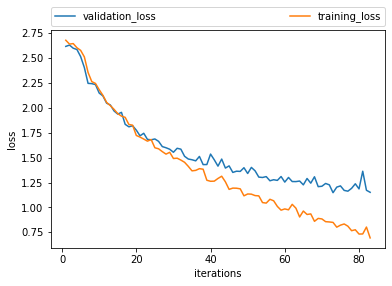

[2.616760845537539,
 2.6302041389324047,
 2.5986003434216536,
 2.585697809855143,
 2.5143846847392894,
 2.4045460842273854,
 2.245523770650228,
 2.2430533832973905,
 2.2331722489109747,
 2.148236045130977,
 2.119590503198129,
 2.0469138622283936,
 2.02832524423246,
 1.9686140925795943,
 1.9373068235538624,
 1.9545241417708221,
 1.8341781474925853,
 1.80924215581682,
 1.8201504018571641,
 1.7757525002514873,
 1.7189555477212977,
 1.744431451514915,
 1.6830498686543218,
 1.6790006116584495,
 1.6873748699824016,
 1.66355155132435,
 1.610834452841017,
 1.5990930619063202,
 1.5841146442625258,
 1.5538033820964672,
 1.593887488047282,
 1.5849315413722285,
 1.5133949341597381,
 1.4859569161026567,
 1.4786922975822732,
 1.4676840790995844,
 1.5119077055542558,
 1.4300118773071855,
 1.4305532420123066,
 1.5355128756275884,
 1.4782562344162553,
 1.4143479488514088,
 1.4854490403775815,
 1.39524836451919,
 1.4170054528448317,
 1.3513956754295915,
 1.3636984118708857,
 1.3616982124469899,
 1.39857

In [35]:
train_save('both', 3, 1)

minibatch:49, epoch:1, iteration:49, training_error:2.669965982437134, validation_error:2.617357455767118
Best loss improvement from inf to 2.617357455767118 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.6256563234329224, validation_error:2.6050907281728892
Best loss improvement from 2.617357455767118 to 2.6050907281728892 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.6058299684524537, validation_error:2.5896446154667783
Best loss improvement from 2.6050907281728892 to 2.5896446154667783 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.5723503160476686, validation_error:2.539072339351361
Best loss improvement from 2.5896446154667783 to 2.539072339351361 in epoch 1
minibatch:17, epoch:2, iteration:249, training_error:2.5558389139175417, validation_error:2.4702307811150184
Best loss improvement from 2.539072339351361 to 2.4702307811150184 in epoch 2
minibatch:67, epoch:2, iteration:299, training_error:2.401532688140869, validation

minibatch:229, epoch:11, iteration:2549, training_error:0.9906515645980835, validation_error:1.1603333835418408
minibatch:47, epoch:12, iteration:2599, training_error:0.9809343802928925, validation_error:1.0736002440635974
Best loss improvement from 1.088460012124135 to 1.0736002440635974 in epoch 12
minibatch:97, epoch:12, iteration:2649, training_error:0.915868524312973, validation_error:1.0814065818603222
minibatch:147, epoch:12, iteration:2699, training_error:0.9289868760108948, validation_error:1.061438656770266
Best loss improvement from 1.0736002440635974 to 1.061438656770266 in epoch 12
minibatch:197, epoch:12, iteration:2749, training_error:0.9620422744750976, validation_error:1.1607979352657611
minibatch:15, epoch:13, iteration:2799, training_error:0.9072028017044067, validation_error:1.065412088082387
minibatch:65, epoch:13, iteration:2849, training_error:0.8854581165313721, validation_error:1.0633066617525542
minibatch:115, epoch:13, iteration:2899, training_error:0.8670555

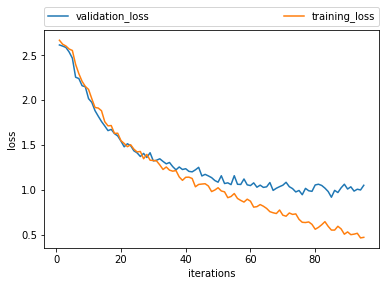

[2.617357455767118,
 2.6050907281728892,
 2.5896446154667783,
 2.539072339351361,
 2.4702307811150184,
 2.2581041684517493,
 2.2433053896977353,
 2.1636103116548977,
 2.1513453676150394,
 2.0193268610880923,
 1.9775094802563007,
 1.8852258828970103,
 1.8233995529321523,
 1.7645055926763094,
 1.7151433046047504,
 1.6632771171056306,
 1.676492833174192,
 1.629763392301706,
 1.60390266088339,
 1.5466208778894865,
 1.4827825885552626,
 1.5168128105310292,
 1.4953729602006764,
 1.4380265886966999,
 1.4148416748413672,
 1.3748279580703149,
 1.4092570910087,
 1.3638429458324726,
 1.4166052754108722,
 1.3256109861227183,
 1.3336526430570161,
 1.3491297318385198,
 1.3197264075279236,
 1.2931071198903596,
 1.3080185881027808,
 1.2617385318646064,
 1.225946375956902,
 1.2579339605111342,
 1.2298620687081263,
 1.2386538478044362,
 1.209120743549787,
 1.2038118357841785,
 1.2261330852141747,
 1.2541411060553331,
 1.1578630621616657,
 1.1756836336392622,
 1.1585481808735774,
 1.139377263876108,
 1.1

In [36]:
train_save('both', 4, 1)

minibatch:49, epoch:1, iteration:49, training_error:2.709328227043152, validation_error:2.65262500445048
Best loss improvement from inf to 2.65262500445048 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.6512788343429565, validation_error:2.655015985171
minibatch:149, epoch:1, iteration:149, training_error:2.6583065509796144, validation_error:2.642577509085337
Best loss improvement from 2.65262500445048 to 2.642577509085337 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.6209659957885743, validation_error:2.6112708350022635
Best loss improvement from 2.642577509085337 to 2.6112708350022635 in epoch 1
minibatch:25, epoch:2, iteration:249, training_error:2.6068780755996706, validation_error:2.6092615723609924
Best loss improvement from 2.6112708350022635 to 2.6092615723609924 in epoch 2
minibatch:75, epoch:2, iteration:299, training_error:2.552579140663147, validation_error:2.5513283411661782
Best loss improvement from 2.6092615723609924 to 2.551328341

minibatch:35, epoch:12, iteration:2499, training_error:1.2155692529678346, validation_error:1.333378290136655
Best loss improvement from 1.3893464505672455 to 1.333378290136655 in epoch 12
minibatch:85, epoch:12, iteration:2549, training_error:1.1934135627746583, validation_error:1.3595622976620991
minibatch:135, epoch:12, iteration:2599, training_error:1.2148936557769776, validation_error:1.3510794540246327
minibatch:185, epoch:12, iteration:2649, training_error:1.1891827750205994, validation_error:1.3062253544727962
Best loss improvement from 1.333378290136655 to 1.3062253544727962 in epoch 12
minibatch:11, epoch:13, iteration:2699, training_error:1.229837646484375, validation_error:1.3212534760435422
minibatch:61, epoch:13, iteration:2749, training_error:1.1909459817409516, validation_error:1.3391166031360626
minibatch:111, epoch:13, iteration:2799, training_error:1.1454922616481782, validation_error:1.3278991629679997
minibatch:161, epoch:13, iteration:2849, training_error:1.191646

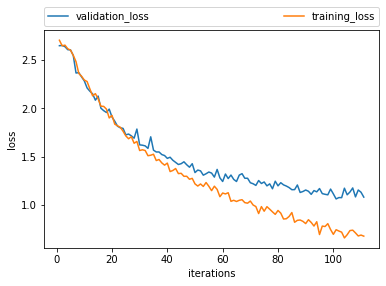

[2.65262500445048,
 2.655015985171,
 2.642577509085337,
 2.6112708350022635,
 2.6092615723609924,
 2.5513283411661782,
 2.3686698178450265,
 2.3723879853884378,
 2.3285993933677673,
 2.28648179769516,
 2.213259239991506,
 2.1797057886918387,
 2.1516364763180413,
 2.0857712775468826,
 2.128710985183716,
 2.0023569216330848,
 1.9771380921204884,
 1.9579149881998699,
 1.993347053726514,
 1.9108733882506688,
 1.867464726169904,
 1.8155713081359863,
 1.7989770422379177,
 1.792979304989179,
 1.725747620066007,
 1.7338769733905792,
 1.7150007237990696,
 1.6910717089970906,
 1.7857848952213924,
 1.6214164992173512,
 1.617988720536232,
 1.6109027862548828,
 1.5847812096277873,
 1.7052041391531627,
 1.5665558179219563,
 1.5474670728047688,
 1.547580103079478,
 1.52071779469649,
 1.5104968796173732,
 1.4810465921958287,
 1.4929038286209106,
 1.4612126499414444,
 1.4392996927102406,
 1.4173611452182133,
 1.4256832897663116,
 1.4454448074102402,
 1.4149407992760341,
 1.3893464505672455,
 1.42547167

In [37]:
train_save('both', 0, 2)

minibatch:49, epoch:1, iteration:49, training_error:2.667164378166199, validation_error:2.650482672232169
Best loss improvement from inf to 2.650482672232169 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.613642692565918, validation_error:2.619219806459215
Best loss improvement from 2.650482672232169 to 2.619219806459215 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.594358038902283, validation_error:2.620936711629232
minibatch:199, epoch:1, iteration:199, training_error:2.5769037914276125, validation_error:2.5723387930128307
Best loss improvement from 2.619219806459215 to 2.5723387930128307 in epoch 1
minibatch:10, epoch:2, iteration:249, training_error:2.5472705125808717, validation_error:2.53126570030495
Best loss improvement from 2.5723387930128307 to 2.53126570030495 in epoch 2
minibatch:60, epoch:2, iteration:299, training_error:2.4649538516998293, validation_error:2.4707921346028647
Best loss improvement from 2.53126570030495 to 2.4707921346

minibatch:20, epoch:12, iteration:2649, training_error:1.1236736512184142, validation_error:1.2160803852257904
Best loss improvement from 1.2242257175622162 to 1.2160803852257904 in epoch 12
minibatch:70, epoch:12, iteration:2699, training_error:1.107559050321579, validation_error:1.236931719161846
minibatch:120, epoch:12, iteration:2749, training_error:1.1611480963230134, validation_error:1.2258924091303791
minibatch:170, epoch:12, iteration:2799, training_error:1.1220988821983338, validation_error:1.2550721632109747
minibatch:220, epoch:12, iteration:2849, training_error:1.0942431938648225, validation_error:1.1310122851972226
Best loss improvement from 1.2160803852257904 to 1.1310122851972226 in epoch 12
minibatch:31, epoch:13, iteration:2899, training_error:1.0920934462547303, validation_error:1.1836355549317819
minibatch:81, epoch:13, iteration:2949, training_error:1.0430593371391297, validation_error:1.1842995882034302
minibatch:131, epoch:13, iteration:2999, training_error:1.0414

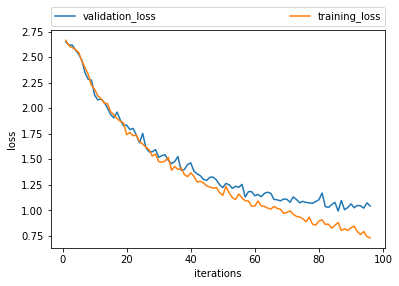

[2.650482672232169,
 2.619219806459215,
 2.620936711629232,
 2.5723387930128307,
 2.53126570030495,
 2.4707921346028647,
 2.3486073635242604,
 2.284840672104447,
 2.2761510301519325,
 2.129622119444388,
 2.08266274134318,
 2.0918093257480197,
 2.0587152110205755,
 2.004091320214448,
 1.9383412643715188,
 1.9066803411201194,
 1.9631546426702429,
 1.8870545007564403,
 1.829887482855055,
 1.8363190006326746,
 1.7917576763365004,
 1.80359301743684,
 1.7395215564303927,
 1.6612637131302446,
 1.7552774438151606,
 1.6142552340472187,
 1.5737014523258916,
 1.5744089462138988,
 1.5956399043401082,
 1.5206648067191795,
 1.536658278218022,
 1.5456405348247952,
 1.4905106756422255,
 1.4578571407883256,
 1.4786538812849257,
 1.528083916063662,
 1.3919508942851313,
 1.399841683882254,
 1.4494956113674022,
 1.4657451267595645,
 1.3842325850769326,
 1.3582398626539443,
 1.339851940119708,
 1.3032939875567402,
 1.2949819255758215,
 1.325622604952918,
 1.3261876989293981,
 1.2983109796488728,
 1.2511949

In [38]:
train_save('both', 1, 2)

minibatch:49, epoch:1, iteration:49, training_error:2.661155252456665, validation_error:2.593541728125678
Best loss improvement from inf to 2.593541728125678 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.6112530851364135, validation_error:2.601833882155242
minibatch:149, epoch:1, iteration:149, training_error:2.601425042152405, validation_error:2.59895450980575
minibatch:199, epoch:1, iteration:199, training_error:2.5726482486724853, validation_error:2.526965061823527
Best loss improvement from 2.593541728125678 to 2.526965061823527 in epoch 1
minibatch:12, epoch:2, iteration:249, training_error:2.5407855796813963, validation_error:2.4851752387152777
Best loss improvement from 2.526965061823527 to 2.4851752387152777 in epoch 2
minibatch:62, epoch:2, iteration:299, training_error:2.456148238182068, validation_error:2.4201297406797058
Best loss improvement from 2.4851752387152777 to 2.4201297406797058 in epoch 2
minibatch:112, epoch:2, iteration:349, training_error:2.3

minibatch:142, epoch:12, iteration:2749, training_error:1.2187902307510377, validation_error:1.3172289177223488
minibatch:192, epoch:12, iteration:2799, training_error:1.2228623354434967, validation_error:1.3079981406529744
minibatch:5, epoch:13, iteration:2849, training_error:1.1933145546913146, validation_error:1.291213611761729
Best loss improvement from 1.304286413722568 to 1.291213611761729 in epoch 13
minibatch:55, epoch:13, iteration:2899, training_error:1.1712926983833314, validation_error:1.2777553929222956
Best loss improvement from 1.291213611761729 to 1.2777553929222956 in epoch 13
minibatch:105, epoch:13, iteration:2949, training_error:1.156504247188568, validation_error:1.314069637545833
minibatch:155, epoch:13, iteration:2999, training_error:1.2120879375934601, validation_error:1.2520258117605139
Best loss improvement from 1.2777553929222956 to 1.2520258117605139 in epoch 13
minibatch:205, epoch:13, iteration:3049, training_error:1.1900417494773865, validation_error:1.23

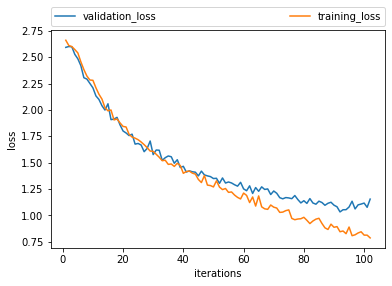

[2.593541728125678,
 2.601833882155242,
 2.59895450980575,
 2.526965061823527,
 2.4851752387152777,
 2.4201297406797058,
 2.3057694523422807,
 2.292991761808042,
 2.2515964772966175,
 2.20978762043847,
 2.133390956454807,
 2.0997796853383384,
 2.040405480949967,
 1.999159022613808,
 2.058830632103814,
 1.908484322053415,
 1.91381272121712,
 1.930120967052601,
 1.8585220398726288,
 1.8008172821115564,
 1.7821162188494648,
 1.7574784314190899,
 1.7708006567425199,
 1.6764233156486794,
 1.6824333976816248,
 1.6678476863437228,
 1.6045616026277896,
 1.6355149039515742,
 1.7057933321705572,
 1.5769250437065407,
 1.6204915179146662,
 1.6183579586170338,
 1.5219208355303164,
 1.5475626080124467,
 1.563827496987802,
 1.556524188430221,
 1.4949103637977883,
 1.5285330436847828,
 1.4543950999224629,
 1.4659242939066004,
 1.411400070896855,
 1.4230520107128002,
 1.4140642528180722,
 1.4101051533663715,
 1.374933335516188,
 1.4201625607631825,
 1.3846575374956485,
 1.375229416070161,
 1.3683418167

In [39]:
train_save('both', 2, 2)

minibatch:49, epoch:1, iteration:49, training_error:2.6698002862930297, validation_error:2.631605280770196
Best loss improvement from inf to 2.631605280770196 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.6435078048706053, validation_error:2.6325271041304976
minibatch:149, epoch:1, iteration:149, training_error:2.6151078653335573, validation_error:2.605670928955078
Best loss improvement from 2.631605280770196 to 2.605670928955078 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.599523873329163, validation_error:2.5339878929985895
Best loss improvement from 2.605670928955078 to 2.5339878929985895 in epoch 1
minibatch:8, epoch:2, iteration:249, training_error:2.500639567375183, validation_error:2.3887757813488997
Best loss improvement from 2.5339878929985895 to 2.3887757813488997 in epoch 2
minibatch:58, epoch:2, iteration:299, training_error:2.415425419807434, validation_error:2.2953426837921143
Best loss improvement from 2.3887757813488997 to 2.2953

minibatch:239, epoch:11, iteration:2649, training_error:1.2197326374053956, validation_error:1.3007407872765153
Best loss improvement from 1.3141161379990753 to 1.3007407872765153 in epoch 11
minibatch:48, epoch:12, iteration:2699, training_error:1.1494963884353637, validation_error:1.2654023192546986
Best loss improvement from 1.3007407872765153 to 1.2654023192546986 in epoch 12
minibatch:98, epoch:12, iteration:2749, training_error:1.1280523228645325, validation_error:1.2291521518318742
Best loss improvement from 1.2654023192546986 to 1.2291521518318742 in epoch 12
minibatch:148, epoch:12, iteration:2799, training_error:1.1768007028102874, validation_error:1.2409187731919464
minibatch:198, epoch:12, iteration:2849, training_error:1.1548376286029816, validation_error:1.2429687115881178
minibatch:7, epoch:13, iteration:2899, training_error:1.1652128851413728, validation_error:1.3147420839027122
minibatch:57, epoch:13, iteration:2949, training_error:1.1141733264923095, validation_error:

minibatch:15, epoch:25, iteration:5799, training_error:0.6611795103549958, validation_error:1.036214973087664
minibatch:65, epoch:25, iteration:5849, training_error:0.6562227571010589, validation_error:1.1011267679708976
minibatch:115, epoch:25, iteration:5899, training_error:0.6638710498809814, validation_error:1.1155205854663142
minibatch:165, epoch:25, iteration:5949, training_error:0.6341736537218093, validation_error:1.07258556065736
minibatch:215, epoch:25, iteration:5999, training_error:0.6493642830848694, validation_error:1.0420247735800567
minibatch:24, epoch:26, iteration:6049, training_error:0.6138271260261535, validation_error:1.0096944438086615
Best loss improvement from 1.0153670178519354 to 1.0096944438086615 in epoch 26
minibatch:74, epoch:26, iteration:6099, training_error:0.5898412764072418, validation_error:1.058206695097464
minibatch:124, epoch:26, iteration:6149, training_error:0.617255482673645, validation_error:1.0441017084651523
minibatch:174, epoch:26, iteratio

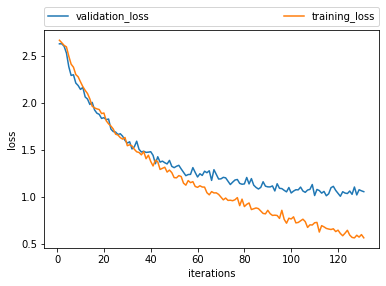

[2.631605280770196,
 2.6325271041304976,
 2.605670928955078,
 2.5339878929985895,
 2.3887757813488997,
 2.2953426837921143,
 2.302504548320064,
 2.2145570384131537,
 2.187809458485356,
 2.1466142689740217,
 2.1678993701934814,
 2.0666396529586226,
 2.0441427495744495,
 1.9864123927222357,
 2.0088270990936845,
 1.9287169332857486,
 1.8937785978670474,
 1.8813485790182043,
 1.838081995646159,
 1.8459921589604131,
 1.824554995254234,
 1.8317403705031783,
 1.724456089514273,
 1.6981349477061518,
 1.6930046832119976,
 1.6673397179003115,
 1.6749145057466295,
 1.648702550817419,
 1.6042423248291016,
 1.5760468950978033,
 1.5894051922692194,
 1.513242032792833,
 1.5363308235451028,
 1.5956863562266033,
 1.5095435469238847,
 1.4808290181336579,
 1.488880581325955,
 1.4766345112412065,
 1.4792812532848783,
 1.483799316264965,
 1.4452393982145522,
 1.356036764604074,
 1.4303607764067474,
 1.3731881380081177,
 1.3835996455616422,
 1.3667571632950395,
 1.3539155809967607,
 1.3914103331389251,
 1.3

In [40]:
train_save('both', 3, 2)

minibatch:49, epoch:1, iteration:49, training_error:2.665573673248291, validation_error:2.647192496519822
Best loss improvement from inf to 2.647192496519822 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.6120977449417113, validation_error:2.6129240897985606
Best loss improvement from 2.647192496519822 to 2.6129240897985606 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.620982265472412, validation_error:2.583249954076914
Best loss improvement from 2.6129240897985606 to 2.583249954076914 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.577938995361328, validation_error:2.536334753036499
Best loss improvement from 2.583249954076914 to 2.536334753036499 in epoch 1
minibatch:17, epoch:2, iteration:249, training_error:2.559310212135315, validation_error:2.4940746013934794
Best loss improvement from 2.536334753036499 to 2.4940746013934794 in epoch 2
minibatch:67, epoch:2, iteration:299, training_error:2.453633303642273, validation_error

minibatch:229, epoch:11, iteration:2549, training_error:1.1249451518058777, validation_error:1.1553795337677002
Best loss improvement from 1.1740864354830522 to 1.1553795337677002 in epoch 11
minibatch:47, epoch:12, iteration:2599, training_error:1.1104139029979705, validation_error:1.1903982231250176
minibatch:97, epoch:12, iteration:2649, training_error:1.0858417987823485, validation_error:1.172183165183434
minibatch:147, epoch:12, iteration:2699, training_error:1.1340050780773163, validation_error:1.1908829303888173
minibatch:197, epoch:12, iteration:2749, training_error:1.0744284069538117, validation_error:1.1206819208768697
Best loss improvement from 1.1553795337677002 to 1.1206819208768697 in epoch 12
minibatch:15, epoch:13, iteration:2799, training_error:1.058016414642334, validation_error:1.1209958241536067
minibatch:65, epoch:13, iteration:2849, training_error:1.0422030341625215, validation_error:1.1360111236572266
minibatch:115, epoch:13, iteration:2899, training_error:1.0463

minibatch:31, epoch:25, iteration:5599, training_error:0.5860444450378418, validation_error:0.96945026746163
minibatch:81, epoch:25, iteration:5649, training_error:0.6086743122339249, validation_error:0.8809351760607499
minibatch:131, epoch:25, iteration:5699, training_error:0.564806210398674, validation_error:0.8687175993735974
minibatch:181, epoch:25, iteration:5749, training_error:0.6298358780145645, validation_error:0.9636331934195298
minibatch:231, epoch:25, iteration:5799, training_error:0.6414730775356293, validation_error:0.8530846994656783
minibatch:49, epoch:26, iteration:5849, training_error:0.5549278664588928, validation_error:0.8818636467823615
minibatch:99, epoch:26, iteration:5899, training_error:0.6017369639873504, validation_error:0.9266667251403515
minibatch:149, epoch:26, iteration:5949, training_error:0.5943984836339951, validation_error:0.9054375359645257
minibatch:199, epoch:26, iteration:5999, training_error:0.5812898290157318, validation_error:0.8549529887162722

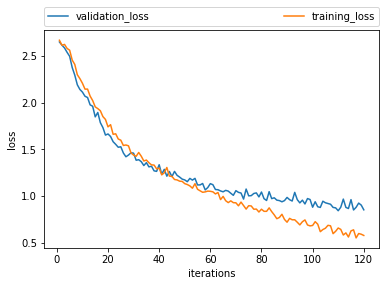

[2.647192496519822,
 2.6129240897985606,
 2.583249954076914,
 2.536334753036499,
 2.4940746013934794,
 2.374314940892733,
 2.2936133329684916,
 2.1901262402534485,
 2.140434278891637,
 2.111884694833022,
 2.067675608855027,
 2.0540266082837033,
 1.9759430931164668,
 1.9607061514487634,
 1.8474172858091502,
 1.8943613767623901,
 1.7858750957709093,
 1.7330730328193078,
 1.6530181628007155,
 1.6648488824184124,
 1.6380506524672875,
 1.5820403786805959,
 1.554179452932798,
 1.5229099347041204,
 1.5281946888336768,
 1.4618231654167175,
 1.421457052230835,
 1.4396200776100159,
 1.4645795730444102,
 1.4598769637254567,
 1.384461359335826,
 1.390017330646515,
 1.3689486567790692,
 1.3277912094042852,
 1.3584070618336017,
 1.3134534702851222,
 1.3205073842635522,
 1.2713000957782452,
 1.2654954057473402,
 1.3364786299375386,
 1.2358407148948083,
 1.2870142597418566,
 1.214205732712379,
 1.2637132910581736,
 1.2099147347303538,
 1.2651669818621416,
 1.2233259563262646,
 1.2045663801523356,
 1.1

In [41]:
train_save('both', 4, 2)

minibatch:49, epoch:1, iteration:49, training_error:2.135475673675537, validation_error:1.9763379830580492
Best loss improvement from inf to 1.9763379830580492 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:1.9876726174354553, validation_error:1.9758150439995985
Best loss improvement from 1.9763379830580492 to 1.9758150439995985 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:1.9731892728805542, validation_error:1.932422935962677
Best loss improvement from 1.9758150439995985 to 1.932422935962677 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:1.892671594619751, validation_error:1.882048716911903
Best loss improvement from 1.932422935962677 to 1.882048716911903 in epoch 1
minibatch:12, epoch:2, iteration:249, training_error:1.8257326316833495, validation_error:1.7944211684740508
Best loss improvement from 1.882048716911903 to 1.7944211684740508 in epoch 2
minibatch:62, epoch:2, iteration:299, training_error:1.7833432579040527, validation

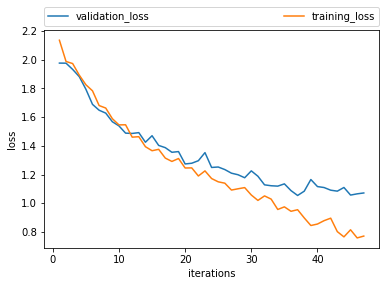

[1.9763379830580492,
 1.9758150439995985,
 1.932422935962677,
 1.882048716911903,
 1.7944211684740508,
 1.6890559700819163,
 1.648268502492171,
 1.6281667489271898,
 1.5681204612438495,
 1.539107804115002,
 1.4887580275535583,
 1.4866806268692017,
 1.4922589659690857,
 1.4254573835776403,
 1.470788497191209,
 1.4032530784606934,
 1.3877564714505122,
 1.3555130041562593,
 1.360287831379817,
 1.274200411943289,
 1.2792697273767912,
 1.2968588975759654,
 1.3531600053493793,
 1.2499262461295495,
 1.252953284061872,
 1.2351679595617147,
 1.2099924568946545,
 1.1990317129171812,
 1.17821882550533,
 1.2261690543248103,
 1.1886642850362337,
 1.1288861311399019,
 1.1224816945882945,
 1.1198499661225538,
 1.1356108853450189,
 1.0886931052574744,
 1.0548065121357257,
 1.084617949449099,
 1.1658964500977442,
 1.1167992170040424,
 1.1100678168810332,
 1.0916306124283717,
 1.0848699372548323,
 1.1104765694874983,
 1.0575615740739381,
 1.0661597045568318,
 1.0722866906569555]

In [42]:
train_save('age', 0, 0)

minibatch:49, epoch:1, iteration:49, training_error:2.0828710436820983, validation_error:1.94861049487673
Best loss improvement from inf to 1.94861049487673 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:1.9378270292282105, validation_error:1.9790079593658447
minibatch:149, epoch:1, iteration:149, training_error:1.9318569898605347, validation_error:1.9507232452261036
minibatch:199, epoch:1, iteration:199, training_error:1.8699781346321105, validation_error:1.8536046250113125
Best loss improvement from 1.94861049487673 to 1.8536046250113125 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:1.8256546878814697, validation_error:1.7817592497529655
Best loss improvement from 1.8536046250113125 to 1.7817592497529655 in epoch 1
minibatch:41, epoch:2, iteration:299, training_error:1.7464977407455444, validation_error:1.7034072136056835
Best loss improvement from 1.7817592497529655 to 1.7034072136056835 in epoch 2
minibatch:91, epoch:2, iteration:349, training_err

minibatch:219, epoch:11, iteration:2799, training_error:0.6246877354383469, validation_error:0.9363583326339722
minibatch:11, epoch:12, iteration:2849, training_error:0.6326252913475037, validation_error:0.9479488566003996
minibatch:61, epoch:12, iteration:2899, training_error:0.6179612356424332, validation_error:1.0438664432229667
minibatch:111, epoch:12, iteration:2949, training_error:0.5840223079919815, validation_error:0.9819056206736071
minibatch:161, epoch:12, iteration:2999, training_error:0.5954655927419662, validation_error:0.9949815293838238
minibatch:211, epoch:12, iteration:3049, training_error:0.5753495299816132, validation_error:0.973536608548
minibatch:3, epoch:13, iteration:3099, training_error:0.5958854097127915, validation_error:0.9747711173419294
Patience ran out at 3099. Ending training


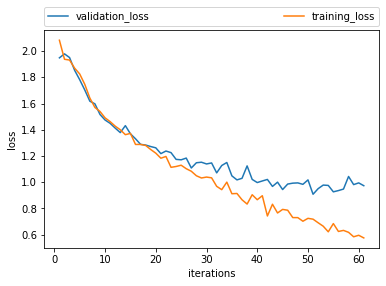

[1.94861049487673,
 1.9790079593658447,
 1.9507232452261036,
 1.8536046250113125,
 1.7817592497529655,
 1.7034072136056835,
 1.6179542788143815,
 1.5977606855589768,
 1.5167813013339866,
 1.4744819238268096,
 1.4491262312593132,
 1.4126460264469016,
 1.3785698660488785,
 1.431562787499921,
 1.3691612564284226,
 1.331416393148488,
 1.2887461596521839,
 1.2835876037334573,
 1.2721461715369389,
 1.2624011409693752,
 1.2182048908595382,
 1.238017620711491,
 1.2258220664386092,
 1.1743579198574197,
 1.1709979464267861,
 1.1842333037277748,
 1.10857781254012,
 1.1485559652591575,
 1.1525867766347424,
 1.1394010946668427,
 1.1471060370576793,
 1.071375534452241,
 1.1275922224439423,
 1.1504902839660645,
 1.0485586791202939,
 1.017863012593368,
 1.029970645904541,
 1.1246050390703926,
 1.0215302890744702,
 0.9975686977649557,
 1.009662911809724,
 1.021309529912883,
 0.9681010492916765,
 1.000594100047802,
 0.9442437147272045,
 0.9860717489801604,
 0.992936163113035,
 0.9949580307664543,
 0.983

In [43]:
train_save('age', 1, 0)

minibatch:49, epoch:1, iteration:49, training_error:2.076725654602051, validation_error:1.9343332668830608
Best loss improvement from inf to 1.9343332668830608 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:1.9589080953598021, validation_error:1.9359227090046323
minibatch:149, epoch:1, iteration:149, training_error:1.935854914188385, validation_error:1.9035031754395058
Best loss improvement from 1.9343332668830608 to 1.9035031754395058 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:1.8974119520187378, validation_error:1.8488246736855343
Best loss improvement from 1.9035031754395058 to 1.8488246736855343 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:1.8634485816955566, validation_error:1.8645106060751553
minibatch:45, epoch:2, iteration:299, training_error:1.8776066517829895, validation_error:1.7417624942187606
Best loss improvement from 1.8488246736855343 to 1.7417624942187606 in epoch 2
minibatch:95, epoch:2, iteration:349, training

minibatch:209, epoch:11, iteration:2749, training_error:0.6931921821832657, validation_error:0.9628473417512302
minibatch:5, epoch:12, iteration:2799, training_error:0.7121248096227646, validation_error:0.9821820999013966
minibatch:55, epoch:12, iteration:2849, training_error:0.6714662998914719, validation_error:0.9061226145974521
minibatch:105, epoch:12, iteration:2899, training_error:0.6267033672332764, validation_error:0.9679398290042219
minibatch:155, epoch:12, iteration:2949, training_error:0.6083537101745605, validation_error:0.9421987574675987
minibatch:205, epoch:12, iteration:2999, training_error:0.5989996027946473, validation_error:0.9665535400653708
minibatch:1, epoch:13, iteration:3049, training_error:0.6268338936567307, validation_error:0.9700755415291622
Patience ran out at 3049. Ending training


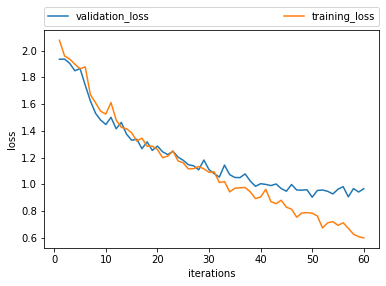

[1.9343332668830608,
 1.9359227090046323,
 1.9035031754395058,
 1.8488246736855343,
 1.8645106060751553,
 1.7417624942187606,
 1.6235282996605183,
 1.530929577761683,
 1.4794425553288952,
 1.4469903255331105,
 1.5005493492915714,
 1.4146682763921803,
 1.4625361582328533,
 1.3752090355445599,
 1.3291903857527108,
 1.3367685901707616,
 1.2661200556261787,
 1.3169816773513268,
 1.2531153107511586,
 1.2858295152927268,
 1.2428118175473706,
 1.222134164695082,
 1.2467274624725868,
 1.2029113070718174,
 1.1790058263416947,
 1.1461122960879886,
 1.1384353658248638,
 1.1079963445663452,
 1.1812543581271995,
 1.1091666098298698,
 1.079754231304958,
 1.053888777206684,
 1.143329854669242,
 1.0719881386592471,
 1.050980284296233,
 1.0498124751551399,
 1.0774117071053078,
 1.0237158084737843,
 0.984568412961631,
 1.0043254289133796,
 0.998991022849905,
 0.9902387980757088,
 1.002369391507116,
 0.9677933721706785,
 0.9480275039015145,
 0.9981185711663345,
 0.9571598398274389,
 0.956158711992461,
 0

In [44]:
train_save('age', 2, 0)

minibatch:49, epoch:1, iteration:49, training_error:2.098179965019226, validation_error:1.927732527256012
Best loss improvement from inf to 1.927732527256012 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:1.936796441078186, validation_error:1.957880687713623
minibatch:149, epoch:1, iteration:149, training_error:1.9474655890464783, validation_error:1.9164840579032898
Best loss improvement from 1.927732527256012 to 1.9164840579032898 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:1.908782331943512, validation_error:1.848955551783244
Best loss improvement from 1.9164840579032898 to 1.848955551783244 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:1.8352936649322509, validation_error:1.7367521365483602
Best loss improvement from 1.848955551783244 to 1.7367521365483602 in epoch 1
minibatch:39, epoch:2, iteration:299, training_error:1.7080368685722351, validation_error:1.6600435415903727
Best loss improvement from 1.7367521365483602 to 1.660

minibatch:199, epoch:11, iteration:2799, training_error:0.657014781832695, validation_error:0.974860554933548
minibatch:249, epoch:11, iteration:2849, training_error:0.679362044930458, validation_error:1.01571626663208
minibatch:39, epoch:12, iteration:2899, training_error:0.6055181020498276, validation_error:1.0139746030171712
minibatch:89, epoch:12, iteration:2949, training_error:0.6021353799104691, validation_error:0.9909379084904989
minibatch:139, epoch:12, iteration:2999, training_error:0.5919030612707138, validation_error:1.0534671723842621
minibatch:189, epoch:12, iteration:3049, training_error:0.6010531675815582, validation_error:0.990280791123708
minibatch:239, epoch:12, iteration:3099, training_error:0.5911054027080536, validation_error:1.0138558387756347
Patience ran out at 3099. Ending training


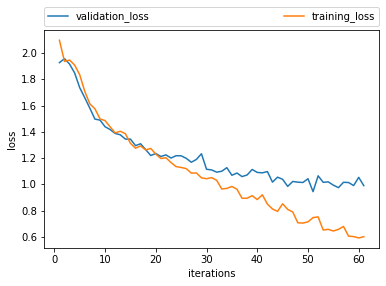

[1.927732527256012,
 1.957880687713623,
 1.9164840579032898,
 1.848955551783244,
 1.7367521365483602,
 1.6600435415903727,
 1.5802720506985983,
 1.4972926139831544,
 1.489721922079722,
 1.439054795106252,
 1.4174944798151652,
 1.3876157681147256,
 1.3777490536371866,
 1.344859238465627,
 1.3447280009587605,
 1.2949968695640564,
 1.3093162695566813,
 1.2650472700595856,
 1.219747887055079,
 1.23479230205218,
 1.2122308353583018,
 1.2245900193850199,
 1.2006415923436482,
 1.2183628459771474,
 1.217536340157191,
 1.1982536971569062,
 1.1684778849283854,
 1.1897491335868835,
 1.2332274238268535,
 1.1150678038597106,
 1.1101021746794382,
 1.0929596642653148,
 1.0999851802984872,
 1.127019727230072,
 1.0693041721979777,
 1.0862306972344717,
 1.0592905322710673,
 1.0714984297752381,
 1.1134830673535665,
 1.0909740408261617,
 1.0878436843554178,
 1.0975284695625305,
 1.0171113004287085,
 1.054756607611974,
 1.0385024130344391,
 0.984682031472524,
 1.022118220726649,
 1.0166728178660074,
 1.014

In [45]:
train_save('age', 3, 0)

minibatch:49, epoch:1, iteration:49, training_error:2.1151965427398682, validation_error:1.939862379005977
Best loss improvement from inf to 1.939862379005977 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:1.960430796146393, validation_error:1.946418855871473
minibatch:149, epoch:1, iteration:149, training_error:1.9277808094024658, validation_error:1.9195384127753121
Best loss improvement from 1.939862379005977 to 1.9195384127753121 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:1.8756864809989928, validation_error:1.8854985705443792
Best loss improvement from 1.9195384127753121 to 1.8854985705443792 in epoch 1
minibatch:1, epoch:2, iteration:249, training_error:1.8432522344589233, validation_error:1.8268411116940635
Best loss improvement from 1.8854985705443792 to 1.8268411116940635 in epoch 2
minibatch:51, epoch:2, iteration:299, training_error:1.8332485008239745, validation_error:1.7030227439744132
Best loss improvement from 1.8268411116940635 to 1.

minibatch:71, epoch:12, iteration:2799, training_error:0.5563617193698883, validation_error:0.945810581956591
minibatch:121, epoch:12, iteration:2849, training_error:0.5048243224620819, validation_error:0.9184765054711274
minibatch:171, epoch:12, iteration:2899, training_error:0.5808266216516494, validation_error:1.0026382356882095
minibatch:221, epoch:12, iteration:2949, training_error:0.5968861168622971, validation_error:0.973742697920118
minibatch:23, epoch:13, iteration:2999, training_error:0.5285284772515297, validation_error:0.9471387778009687
minibatch:73, epoch:13, iteration:3049, training_error:0.48783807694911957, validation_error:0.9993720884834018
minibatch:123, epoch:13, iteration:3099, training_error:0.5096124976873397, validation_error:1.0764999325786317
Patience ran out at 3099. Ending training


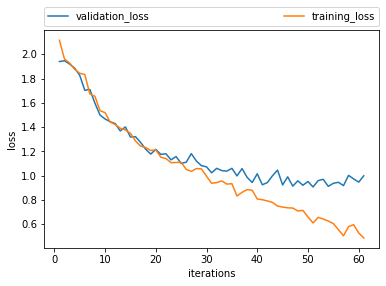

[1.939862379005977,
 1.946418855871473,
 1.9195384127753121,
 1.8854985705443792,
 1.8268411116940635,
 1.7030227439744132,
 1.7100753017834254,
 1.5970392184598106,
 1.4993845863001687,
 1.4672193442072188,
 1.4442538278443473,
 1.4289625074182237,
 1.3686605564185552,
 1.401651063135692,
 1.3184942986283983,
 1.3210863236870085,
 1.274505696126393,
 1.2183380212102617,
 1.1778254913432258,
 1.2164021815572466,
 1.1752308862549918,
 1.180560263139861,
 1.1306328241314207,
 1.1574962522302354,
 1.100785561970302,
 1.1113522499799728,
 1.1815859292234694,
 1.1207925847598486,
 1.0825247445276804,
 1.0729779217924391,
 1.0240042869533812,
 1.060705189193998,
 1.0420818371432168,
 1.0375036533389772,
 1.0606191924640112,
 0.9983991171632495,
 1.0588550716638565,
 0.9867661552769798,
 0.9441857806273869,
 1.0157617287976402,
 0.9254475789410728,
 0.9434541123253959,
 0.9997326923268182,
 1.046150884457997,
 0.924145944416523,
 0.9906523589576993,
 0.9141032482896533,
 0.95763042143413,
 0.

In [46]:
train_save('age', 4, 0)

minibatch:49, epoch:1, iteration:49, training_error:2.12414514541626, validation_error:1.9945948078082159
Best loss improvement from inf to 1.9945948078082159 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:1.9925479769706727, validation_error:1.9991054443212657
minibatch:149, epoch:1, iteration:149, training_error:1.9674210953712463, validation_error:1.9539740498249347
Best loss improvement from 1.9945948078082159 to 1.9539740498249347 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:1.9454285669326783, validation_error:1.9791164489892812
minibatch:12, epoch:2, iteration:249, training_error:1.923731017112732, validation_error:1.8613070295407221
Best loss improvement from 1.9539740498249347 to 1.8613070295407221 in epoch 2
minibatch:62, epoch:2, iteration:299, training_error:1.8119408082962036, validation_error:1.7955171649272625
Best loss improvement from 1.8613070295407221 to 1.7955171649272625 in epoch 2
minibatch:112, epoch:2, iteration:349, training_

minibatch:55, epoch:13, iteration:2899, training_error:0.7594279605150223, validation_error:1.0133358652775104
Best loss improvement from 1.013486046057481 to 1.0133358652775104 in epoch 13
minibatch:105, epoch:13, iteration:2949, training_error:0.7696940934658051, validation_error:1.046197120959942
minibatch:155, epoch:13, iteration:2999, training_error:0.7841444063186646, validation_error:1.0733461334155157
minibatch:205, epoch:13, iteration:3049, training_error:0.7757133537530899, validation_error:1.0105340136931493
Best loss improvement from 1.0133358652775104 to 1.0105340136931493 in epoch 13
minibatch:18, epoch:14, iteration:3099, training_error:0.7690565466880799, validation_error:0.9734173990212954
Best loss improvement from 1.0105340136931493 to 0.9734173990212954 in epoch 14
minibatch:68, epoch:14, iteration:3149, training_error:0.7410303342342377, validation_error:0.9966862683112805
minibatch:118, epoch:14, iteration:3199, training_error:0.7131703853607178, validation_error:

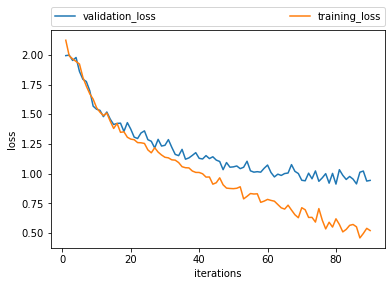

[1.9945948078082159,
 1.9991054443212657,
 1.9539740498249347,
 1.9791164489892812,
 1.8613070295407221,
 1.7955171649272625,
 1.7768092293005724,
 1.6998323477231538,
 1.5692979510013874,
 1.5434131530615,
 1.5338039627441993,
 1.4807385022823627,
 1.5200709425486052,
 1.4596248727578383,
 1.4143768961612995,
 1.4236812545703008,
 1.4260215850976796,
 1.3560845347551198,
 1.4304208251146169,
 1.375588242824261,
 1.308386660539187,
 1.296799911902501,
 1.3435175510553212,
 1.3610358696717482,
 1.2868633774610667,
 1.2735215654739966,
 1.2171357044806848,
 1.2897348495630117,
 1.2332715048239782,
 1.2396688415453985,
 1.2874717781176934,
 1.2224313364579127,
 1.1629733328635876,
 1.1525573707543886,
 1.2053825969879444,
 1.122413871379999,
 1.1335131525993347,
 1.1545848158689647,
 1.1775924609257624,
 1.1300924191108117,
 1.1243576751305506,
 1.1528405203269079,
 1.127945377276494,
 1.1430491277804742,
 1.115067640176186,
 1.1034488838452559,
 1.0344337591758141,
 1.0945400595664978,
 

In [47]:
train_save('age', 0, 1)

minibatch:49, epoch:1, iteration:49, training_error:2.0748919820785523, validation_error:1.962131274157557
Best loss improvement from inf to 1.962131274157557 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:1.9343212819099427, validation_error:1.944886248687218
Best loss improvement from 1.962131274157557 to 1.944886248687218 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:1.8914496159553529, validation_error:1.9487048921913936
minibatch:199, epoch:1, iteration:199, training_error:1.8870719861984253, validation_error:1.891734579513813
Best loss improvement from 1.944886248687218 to 1.891734579513813 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:1.860370728969574, validation_error:1.8119569688007748
Best loss improvement from 1.891734579513813 to 1.8119569688007748 in epoch 1
minibatch:41, epoch:2, iteration:299, training_error:1.7460381698608398, validation_error:1.6537972976421487
Best loss improvement from 1.8119569688007748 to 1.653

minibatch:219, epoch:11, iteration:2799, training_error:0.8144248485565185, validation_error:0.9179730250917632
minibatch:11, epoch:12, iteration:2849, training_error:0.7912926518917084, validation_error:0.8956144575414986
Best loss improvement from 0.9118544767642843 to 0.8956144575414986 in epoch 12
minibatch:61, epoch:12, iteration:2899, training_error:0.7315157294273377, validation_error:0.9277838941278129
minibatch:111, epoch:12, iteration:2949, training_error:0.7324526405334473, validation_error:0.9968198167866674
minibatch:161, epoch:12, iteration:2999, training_error:0.7409502667188644, validation_error:0.9115528197124086
minibatch:211, epoch:12, iteration:3049, training_error:0.7419788300991058, validation_error:0.9022775662356409
minibatch:3, epoch:13, iteration:3099, training_error:0.7218121838569641, validation_error:0.9446611856592113
minibatch:53, epoch:13, iteration:3149, training_error:0.7051626121997834, validation_error:0.8758526958268265
Best loss improvement from 0.

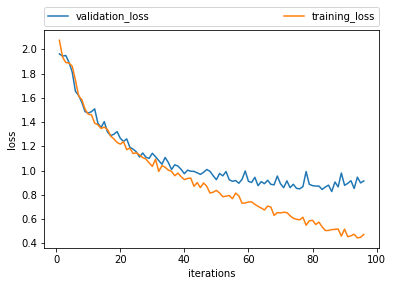

[1.962131274157557,
 1.944886248687218,
 1.9487048921913936,
 1.891734579513813,
 1.8119569688007748,
 1.6537972976421487,
 1.6199906077878228,
 1.5624718912716569,
 1.4862607059807613,
 1.4746126347574695,
 1.48560159370817,
 1.5091473398537472,
 1.3916792664034614,
 1.3549447018524696,
 1.4039578108951962,
 1.31848052863417,
 1.2881433922668983,
 1.2998889191397305,
 1.3215325084225884,
 1.266388529333575,
 1.240344616873511,
 1.2614493657802712,
 1.192240044988435,
 1.1769503581112828,
 1.1545992699162713,
 1.1120258343630824,
 1.1450554749061321,
 1.1096959956761063,
 1.1006223518272926,
 1.1430503027192478,
 1.1138755041977455,
 1.0827002484222938,
 1.0525299536770787,
 1.1084047638136765,
 1.0668365708712875,
 1.0089514255523682,
 1.047879963085569,
 1.0371680465237847,
 1.009646553417732,
 0.9744933494206133,
 1.0034363557552468,
 0.9946502734874857,
 0.9933341556581957,
 0.9817058012403291,
 0.968666672706604,
 0.9858891943405415,
 1.0092250581445366,
 0.9937923118985933,
 0.95

In [48]:
train_save('age', 1, 1)

minibatch:49, epoch:1, iteration:49, training_error:2.07426353931427, validation_error:1.9378194069040233
Best loss improvement from inf to 1.9378194069040233 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:1.9593927597999572, validation_error:1.9297517496964027
Best loss improvement from 1.9378194069040233 to 1.9297517496964027 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:1.9426056051254272, validation_error:1.889961604414315
Best loss improvement from 1.9297517496964027 to 1.889961604414315 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:1.8496738076210022, validation_error:1.8563377528355038
Best loss improvement from 1.889961604414315 to 1.8563377528355038 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:1.767345564365387, validation_error:1.6669599804384956
Best loss improvement from 1.8563377528355038 to 1.6669599804384956 in epoch 1
minibatch:45, epoch:2, iteration:299, training_error:1.6713288879394532, validat

minibatch:55, epoch:12, iteration:2849, training_error:0.8222710978984833, validation_error:0.9172524974263948
Best loss improvement from 0.9364517701083216 to 0.9172524974263948 in epoch 12
minibatch:105, epoch:12, iteration:2899, training_error:0.833559296131134, validation_error:0.9872579780118219
minibatch:155, epoch:12, iteration:2949, training_error:0.7972995567321778, validation_error:0.9157571196556091
Best loss improvement from 0.9172524974263948 to 0.9157571196556091 in epoch 12
minibatch:205, epoch:12, iteration:2999, training_error:0.8299391376972198, validation_error:0.9414399245689655
minibatch:1, epoch:13, iteration:3049, training_error:0.8160564506053924, validation_error:0.9173099891892795
minibatch:51, epoch:13, iteration:3099, training_error:0.7621069979667664, validation_error:0.9553857507376835
minibatch:101, epoch:13, iteration:3149, training_error:0.755673571228981, validation_error:0.897861897945404
Best loss improvement from 0.9157571196556091 to 0.897861897945

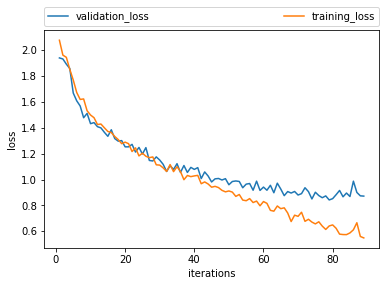

[1.9378194069040233,
 1.9297517496964027,
 1.889961604414315,
 1.8563377528355038,
 1.6669599804384956,
 1.6071085601017392,
 1.5671163715165237,
 1.476672180767717,
 1.509783650266713,
 1.430628912202243,
 1.438928114956823,
 1.407535166575991,
 1.3982362336125866,
 1.3640196282288124,
 1.333320165502614,
 1.383766901904139,
 1.3154955526878094,
 1.295838816412564,
 1.3000986699400277,
 1.2518906675536057,
 1.2519545123494904,
 1.2711012897820309,
 1.211609807507745,
 1.247384054907437,
 1.19679214625523,
 1.2459961052598625,
 1.1470824952783256,
 1.1428408704955002,
 1.1745291598911942,
 1.1501741388748432,
 1.1167177331858669,
 1.0617815235565449,
 1.1063089987327313,
 1.077818385485945,
 1.1219896900242772,
 1.0544870762989438,
 1.1078672779017482,
 1.0545943913788631,
 1.0934630673507164,
 1.0779598334739948,
 1.0915869515517662,
 1.0071885462464958,
 1.0583920355500847,
 1.0268806794594074,
 0.9809960435176718,
 1.005045839424791,
 1.0079475559037308,
 0.996188262413288,
 1.00648

In [49]:
train_save('age', 2, 1)

minibatch:49, epoch:1, iteration:49, training_error:2.092133958339691, validation_error:1.9409544905026754
Best loss improvement from inf to 1.9409544905026754 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:1.9520356702804564, validation_error:1.9320989727973938
Best loss improvement from 1.9409544905026754 to 1.9320989727973938 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:1.9502390122413635, validation_error:1.911566162109375
Best loss improvement from 1.9320989727973938 to 1.911566162109375 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:1.8818147110939025, validation_error:1.8402229110399881
Best loss improvement from 1.911566162109375 to 1.8402229110399881 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:1.7771305179595946, validation_error:1.6925867160161336
Best loss improvement from 1.8402229110399881 to 1.6925867160161336 in epoch 1
minibatch:39, epoch:2, iteration:299, training_error:1.6584685230255127, valid

minibatch:49, epoch:11, iteration:2649, training_error:0.8383221960067749, validation_error:0.9830129603544872
minibatch:99, epoch:11, iteration:2699, training_error:0.8209292328357697, validation_error:0.9584712326526642
Best loss improvement from 0.9783805509408315 to 0.9584712326526642 in epoch 11
minibatch:149, epoch:11, iteration:2749, training_error:0.7983813643455505, validation_error:0.9832062661647797
minibatch:199, epoch:11, iteration:2799, training_error:0.8116253042221069, validation_error:0.9997403860092163
minibatch:249, epoch:11, iteration:2849, training_error:0.8166564929485322, validation_error:1.0478515028953552
minibatch:39, epoch:12, iteration:2899, training_error:0.7843273627758026, validation_error:1.0079146007696786
minibatch:89, epoch:12, iteration:2949, training_error:0.7661972773075104, validation_error:0.9571357647577922
Best loss improvement from 0.9584712326526642 to 0.9571357647577922 in epoch 12
minibatch:139, epoch:12, iteration:2999, training_error:0.78

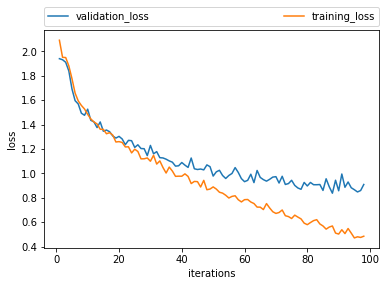

[1.9409544905026754,
 1.9320989727973938,
 1.911566162109375,
 1.8402229110399881,
 1.6925867160161336,
 1.5966154098510743,
 1.5692495385805765,
 1.4937923351923625,
 1.4767260471979777,
 1.5268754482269287,
 1.4356156229972838,
 1.4226672291755675,
 1.3756089329719543,
 1.4220822691917419,
 1.345971163113912,
 1.3557791749636332,
 1.341943089167277,
 1.3072912534077963,
 1.2898657699426015,
 1.3037424047787984,
 1.2824641386667888,
 1.2355296909809113,
 1.2711679657300314,
 1.2683777074019114,
 1.2131790240605673,
 1.2347578247388205,
 1.2040417194366455,
 1.202659551302592,
 1.146031375726064,
 1.2296810229619344,
 1.1607917269070944,
 1.1787018259366353,
 1.128979065020879,
 1.1269665598869323,
 1.1167294363180795,
 1.1026437024275462,
 1.092082937558492,
 1.059675431251526,
 1.062689874569575,
 1.0894122540950775,
 1.067928926150004,
 1.0492478807767232,
 1.1263368944327037,
 1.0380691270033517,
 1.032135194540024,
 1.0359830836455026,
 1.0291065295537314,
 1.0698747316996255,
 1.

In [50]:
train_save('age', 3, 1)

minibatch:49, epoch:1, iteration:49, training_error:2.103826315402985, validation_error:1.9892187203679765
Best loss improvement from inf to 1.9892187203679765 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:1.978773102760315, validation_error:1.9857364978109087
Best loss improvement from 1.9892187203679765 to 1.9857364978109087 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:1.9298776125907897, validation_error:1.918861938374383
Best loss improvement from 1.9857364978109087 to 1.918861938374383 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:1.922430145740509, validation_error:1.9375595365251814
minibatch:1, epoch:2, iteration:249, training_error:1.8845023965835572, validation_error:1.9098011893885476
Best loss improvement from 1.918861938374383 to 1.9098011893885476 in epoch 2
minibatch:51, epoch:2, iteration:299, training_error:1.8072604513168335, validation_error:1.8043957480362482
Best loss improvement from 1.9098011893885476 to 1.8

minibatch:71, epoch:12, iteration:2799, training_error:0.7627629709243774, validation_error:0.964748061129025
minibatch:121, epoch:12, iteration:2849, training_error:0.7665862703323364, validation_error:0.9620218010885375
minibatch:171, epoch:12, iteration:2899, training_error:0.7804487651586532, validation_error:0.9108080629791532
Best loss improvement from 0.9173992872238159 to 0.9108080629791532 in epoch 12
minibatch:221, epoch:12, iteration:2949, training_error:0.7463372087478638, validation_error:0.9226716565234321
minibatch:23, epoch:13, iteration:2999, training_error:0.7712670969963074, validation_error:0.9105374898229327
Best loss improvement from 0.9108080629791532 to 0.9105374898229327 in epoch 13
minibatch:73, epoch:13, iteration:3049, training_error:0.6829121452569962, validation_error:0.917490833571979
minibatch:123, epoch:13, iteration:3099, training_error:0.7460241639614105, validation_error:0.9016723803111485
Best loss improvement from 0.9105374898229327 to 0.9016723803

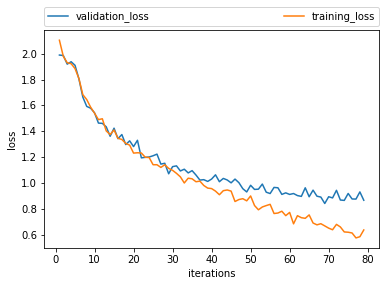

[1.9892187203679765,
 1.9857364978109087,
 1.918861938374383,
 1.9375595365251814,
 1.9098011893885476,
 1.8043957480362482,
 1.6636681301253182,
 1.5916650891304016,
 1.5779452919960022,
 1.5422880053520203,
 1.4626593164035253,
 1.460415197270257,
 1.4336842128208704,
 1.360734903386661,
 1.4231767739568437,
 1.3421838624136788,
 1.3739154253687178,
 1.2963520799364363,
 1.32522428887231,
 1.2808205442769187,
 1.3295565034661974,
 1.1936042542968477,
 1.197676616055625,
 1.200312974197524,
 1.2097362641777312,
 1.222478768655232,
 1.1451814600399561,
 1.1516664581639426,
 1.0703433283737727,
 1.125536675964083,
 1.1315572495971407,
 1.0922815693276269,
 1.105632722377777,
 1.0770181651626314,
 1.0946587813752038,
 1.0605511856930596,
 1.0216091466801507,
 1.0247677628483092,
 1.011213739003454,
 1.0295215461935316,
 1.0623409641640527,
 1.0089285927159446,
 1.0344289477382387,
 1.0223370811768941,
 1.0002349380935942,
 1.0292199445622308,
 1.0014135645968574,
 0.9548390997307641,
 0.

In [51]:
train_save('age', 4, 1)

minibatch:49, epoch:1, iteration:49, training_error:2.1283642578125, validation_error:2.0098154819928684
Best loss improvement from inf to 2.0098154819928684 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:1.9868764662742615, validation_error:1.9817349910736084
Best loss improvement from 2.0098154819928684 to 1.9817349910736084 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:1.980355019569397, validation_error:1.960660471366002
Best loss improvement from 1.9817349910736084 to 1.960660471366002 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:1.958440809249878, validation_error:1.935766834479112
Best loss improvement from 1.960660471366002 to 1.935766834479112 in epoch 1
minibatch:12, epoch:2, iteration:249, training_error:1.9188155651092529, validation_error:1.8795956464914174
Best loss improvement from 1.935766834479112 to 1.8795956464914174 in epoch 2
minibatch:62, epoch:2, iteration:299, training_error:1.866071183681488, validation_err

minibatch:42, epoch:12, iteration:2649, training_error:0.9760829973220825, validation_error:1.0844372442135444
minibatch:92, epoch:12, iteration:2699, training_error:0.9190093529224396, validation_error:1.0642872521510491
minibatch:142, epoch:12, iteration:2749, training_error:0.9379859578609466, validation_error:1.069308849481436
minibatch:192, epoch:12, iteration:2799, training_error:0.9264166617393493, validation_error:1.0383197711064265
Best loss improvement from 1.060162794131499 to 1.0383197711064265 in epoch 12
minibatch:5, epoch:13, iteration:2849, training_error:0.9023492801189422, validation_error:1.0500101309556227
minibatch:55, epoch:13, iteration:2899, training_error:0.8437096405029297, validation_error:1.007307971899326
Best loss improvement from 1.0383197711064265 to 1.007307971899326 in epoch 13
minibatch:105, epoch:13, iteration:2949, training_error:0.9199136221408843, validation_error:1.0106462331918569
minibatch:155, epoch:13, iteration:2999, training_error:0.8807138

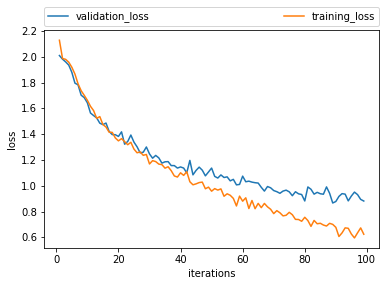

[2.0098154819928684,
 1.9817349910736084,
 1.960660471366002,
 1.935766834479112,
 1.8795956464914174,
 1.7957756931965168,
 1.782743486074301,
 1.7024834981331458,
 1.683265887773954,
 1.6435135832199683,
 1.5643911224145155,
 1.544672035253965,
 1.5264075765242944,
 1.4855504219348614,
 1.474310109248528,
 1.486470823104565,
 1.4217062225708594,
 1.396913510102492,
 1.3960196788494403,
 1.3827231847322905,
 1.4182029504042406,
 1.3222730526557336,
 1.343911051750183,
 1.3935976945436919,
 1.3385612551982586,
 1.3024086172764118,
 1.255646756062141,
 1.2604809678517854,
 1.3008473905233235,
 1.24739159987523,
 1.2139814496040344,
 1.235573940552198,
 1.2163615547693694,
 1.1758856658752148,
 1.185970934537741,
 1.1875436581098116,
 1.1566549103993635,
 1.1566995817881365,
 1.1374187607031603,
 1.1461916382496173,
 1.137494057416916,
 1.1007152933340807,
 1.1967396025474255,
 1.0850051801938276,
 1.119322066123669,
 1.1447754548146174,
 1.1209762348578527,
 1.0771507506187146,
 1.10710

In [52]:
train_save('age', 0, 2)

minibatch:49, epoch:1, iteration:49, training_error:2.048886740207672, validation_error:1.952934166480755
Best loss improvement from inf to 1.952934166480755 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:1.9482149291038513, validation_error:1.9497240617357452
Best loss improvement from 1.952934166480755 to 1.9497240617357452 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:1.9004999113082885, validation_error:1.8913424713858242
Best loss improvement from 1.9497240617357452 to 1.8913424713858242 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:1.8566206550598146, validation_error:1.868312120437622
Best loss improvement from 1.8913424713858242 to 1.868312120437622 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:1.839109845161438, validation_error:1.8102422541585461
Best loss improvement from 1.868312120437622 to 1.8102422541585461 in epoch 1
minibatch:41, epoch:2, iteration:299, training_error:1.7733040690422057, validatio

minibatch:227, epoch:10, iteration:2549, training_error:0.9855797719955445, validation_error:0.9900556556109724
minibatch:19, epoch:11, iteration:2599, training_error:0.9192099893093109, validation_error:1.002032610876807
minibatch:69, epoch:11, iteration:2649, training_error:0.9402688658237457, validation_error:1.0092393303739613
minibatch:119, epoch:11, iteration:2699, training_error:0.901815015077591, validation_error:0.951041866993082
Best loss improvement from 0.9895324748137901 to 0.951041866993082 in epoch 11
minibatch:169, epoch:11, iteration:2749, training_error:0.9121031963825226, validation_error:1.032326116644103
minibatch:219, epoch:11, iteration:2799, training_error:0.9099094450473786, validation_error:0.9893706399818947
minibatch:11, epoch:12, iteration:2849, training_error:0.876874543428421, validation_error:0.9597492135804275
minibatch:61, epoch:12, iteration:2899, training_error:0.8834228634834289, validation_error:0.9424699174946752
Best loss improvement from 0.95104

minibatch:181, epoch:22, iteration:5599, training_error:0.5845478343963623, validation_error:0.7426986622399298
Best loss improvement from 0.7600714913729963 to 0.7426986622399298 in epoch 22
minibatch:231, epoch:22, iteration:5649, training_error:0.54762067258358, validation_error:0.7567345386949079
minibatch:23, epoch:23, iteration:5699, training_error:0.5440843635797501, validation_error:0.7762024227915139
minibatch:73, epoch:23, iteration:5749, training_error:0.5481089746952057, validation_error:0.7729218078070673
minibatch:123, epoch:23, iteration:5799, training_error:0.529005001783371, validation_error:0.7938644670206925
minibatch:173, epoch:23, iteration:5849, training_error:0.5746126961708069, validation_error:0.7905698243913979
minibatch:223, epoch:23, iteration:5899, training_error:0.5564494103193283, validation_error:0.7364444835432644
Best loss improvement from 0.7426986622399298 to 0.7364444835432644 in epoch 23
minibatch:15, epoch:24, iteration:5949, training_error:0.5292

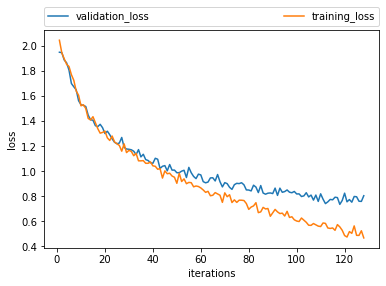

[1.952934166480755,
 1.9497240617357452,
 1.8913424713858242,
 1.868312120437622,
 1.8102422541585461,
 1.7028854468773151,
 1.6769316566401515,
 1.652516377383265,
 1.56539091570624,
 1.5331381970438465,
 1.5281375194418019,
 1.519045143291868,
 1.4500847684926,
 1.4125104238247048,
 1.4097711176707828,
 1.3658177071604236,
 1.3580707229416946,
 1.3766073933963119,
 1.3496028595957263,
 1.3027907137213082,
 1.3215418540198227,
 1.2935377441603562,
 1.2604951858520508,
 1.2331997320569794,
 1.2216183173245396,
 1.2266454943295182,
 1.2715300979285404,
 1.1918667082128853,
 1.1792977575598091,
 1.1771519060792595,
 1.1729539303944028,
 1.1615024702302341,
 1.1343058101062118,
 1.174402384922422,
 1.116108960118787,
 1.1371315368290604,
 1.0945128284651657,
 1.0873225105219875,
 1.069340989507478,
 1.0651645290440526,
 1.1051713146012405,
 1.0974889171534572,
 1.0233883837173725,
 1.0410728105183304,
 1.0464106715958694,
 1.004890096598658,
 1.0550303048100964,
 1.0103836922809994,
 1.01

In [53]:
train_save('age', 1, 2)

minibatch:49, epoch:1, iteration:49, training_error:2.1108318567276, validation_error:1.9265789040203751
Best loss improvement from inf to 1.9265789040203751 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:1.9588629817962646, validation_error:1.9577926027363743
minibatch:149, epoch:1, iteration:149, training_error:1.9493841075897216, validation_error:1.905559387700311
Best loss improvement from 1.9265789040203751 to 1.905559387700311 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:1.919017355442047, validation_error:1.891581991623188
Best loss improvement from 1.905559387700311 to 1.891581991623188 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:1.881420407295227, validation_error:1.866736338056367
Best loss improvement from 1.891581991623188 to 1.866736338056367 in epoch 1
minibatch:45, epoch:2, iteration:299, training_error:1.8727864527702331, validation_error:1.7882572987983967
Best loss improvement from 1.866736338056367 to 1.7882572

minibatch:209, epoch:11, iteration:2749, training_error:0.9582597684860229, validation_error:0.9773491579910805
minibatch:5, epoch:12, iteration:2799, training_error:0.9328166431188584, validation_error:1.0316930372139503
minibatch:55, epoch:12, iteration:2849, training_error:0.9209716427326202, validation_error:0.9553055208304833
Best loss improvement from 0.9710136282032934 to 0.9553055208304833 in epoch 12
minibatch:105, epoch:12, iteration:2899, training_error:0.9007363855838776, validation_error:0.9390624350514906
Best loss improvement from 0.9553055208304833 to 0.9390624350514906 in epoch 12
minibatch:155, epoch:12, iteration:2949, training_error:0.8659060251712799, validation_error:0.9763850425851757
minibatch:205, epoch:12, iteration:2999, training_error:0.9167730605602264, validation_error:0.9684089915505771
minibatch:1, epoch:13, iteration:3049, training_error:0.9332685744762421, validation_error:1.1046421014029404
minibatch:51, epoch:13, iteration:3099, training_error:0.9095

minibatch:57, epoch:24, iteration:5899, training_error:0.550144522190094, validation_error:0.808465202306879
minibatch:107, epoch:24, iteration:5949, training_error:0.5782770979404449, validation_error:0.7910256529676503
minibatch:157, epoch:24, iteration:5999, training_error:0.504531536102295, validation_error:0.8455235074306356
minibatch:207, epoch:24, iteration:6049, training_error:0.5447453045845032, validation_error:0.7956086068317808
minibatch:3, epoch:25, iteration:6099, training_error:0.5186924621462822, validation_error:0.8397295413346126
minibatch:53, epoch:25, iteration:6149, training_error:0.5183920335769653, validation_error:0.7950612573788084
minibatch:103, epoch:25, iteration:6199, training_error:0.5062456092238427, validation_error:0.7969458411479818
minibatch:153, epoch:25, iteration:6249, training_error:0.5411777490377426, validation_error:0.7761257927993248
minibatch:203, epoch:25, iteration:6299, training_error:0.5537966442108154, validation_error:0.7869073532778641

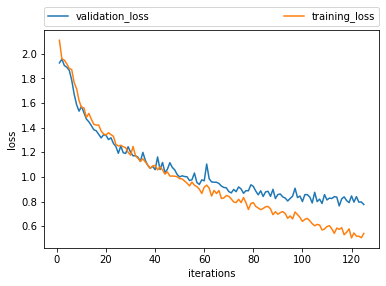

[1.9265789040203751,
 1.9577926027363743,
 1.905559387700311,
 1.891581991623188,
 1.866736338056367,
 1.7882572987983967,
 1.6731723588088463,
 1.5871645335493416,
 1.5345565162856003,
 1.5731066095417943,
 1.5215845272458832,
 1.4704147618392418,
 1.4477935536154385,
 1.4175220399067319,
 1.3839873486551746,
 1.3752154769568607,
 1.3462102783137355,
 1.3174870343043887,
 1.3429472816401515,
 1.3372321046631912,
 1.3038125408106838,
 1.3181543021366513,
 1.272436943547479,
 1.2479416131973267,
 1.1921044053702519,
 1.251503504555801,
 1.1965665796707416,
 1.1911744413704708,
 1.2455473480553463,
 1.2004396216622715,
 1.1712423439683586,
 1.1728518728552193,
 1.1603320487614335,
 1.1258947828720356,
 1.1996798659193104,
 1.1350463156042427,
 1.0940122768796723,
 1.0711384806139717,
 1.0858462165141929,
 1.059179162156993,
 1.1623257768565212,
 1.0598102540805423,
 1.1178841960841213,
 1.0345850093611355,
 1.0627871176292156,
 1.1157960398443814,
 1.0772895073068554,
 1.0565445834192737

In [54]:
train_save('age', 2, 2)

minibatch:49, epoch:1, iteration:49, training_error:2.0548736524581908, validation_error:1.967153537273407
Best loss improvement from inf to 1.967153537273407 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:1.9703387546539306, validation_error:1.9241897265116374
Best loss improvement from 1.967153537273407 to 1.9241897265116374 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:1.945791370868683, validation_error:1.8881848891576132
Best loss improvement from 1.9241897265116374 to 1.8881848891576132 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:1.8891408586502074, validation_error:1.851467994848887
Best loss improvement from 1.8881848891576132 to 1.851467994848887 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:1.7714087796211242, validation_error:1.7115627725919087
Best loss improvement from 1.851467994848887 to 1.7115627725919087 in epoch 1
minibatch:39, epoch:2, iteration:299, training_error:1.7009917569160462, validati

minibatch:39, epoch:12, iteration:2899, training_error:0.9325356686115265, validation_error:1.0606295088926951
minibatch:89, epoch:12, iteration:2949, training_error:0.8821777641773224, validation_error:1.0334874401489893
minibatch:139, epoch:12, iteration:2999, training_error:0.8833230483531952, validation_error:0.9953199525674185
Best loss improvement from 1.0012577513853709 to 0.9953199525674185 in epoch 12
minibatch:189, epoch:12, iteration:3049, training_error:0.8685728764533996, validation_error:0.992599101861318
Best loss improvement from 0.9953199525674185 to 0.992599101861318 in epoch 12
minibatch:239, epoch:12, iteration:3099, training_error:0.9191727924346924, validation_error:1.0122289697329203
minibatch:29, epoch:13, iteration:3149, training_error:0.8574953496456146, validation_error:1.013538416226705
minibatch:79, epoch:13, iteration:3199, training_error:0.8718278992176056, validation_error:0.9929323335488637
minibatch:129, epoch:13, iteration:3249, training_error:0.85467

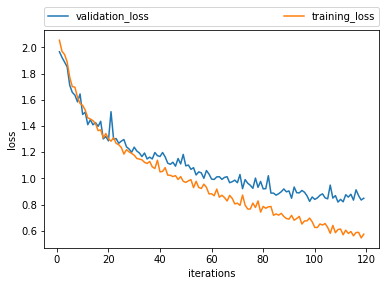

[1.967153537273407,
 1.9241897265116374,
 1.8881848891576132,
 1.851467994848887,
 1.7115627725919087,
 1.6569000641504923,
 1.6363468766212463,
 1.5846525430679321,
 1.6452051917711894,
 1.488606365521749,
 1.505901829401652,
 1.4105372865994772,
 1.4480712334314982,
 1.409704295794169,
 1.4261287569999694,
 1.3976321379343668,
 1.4364852825800578,
 1.3018924017747244,
 1.3201059063275655,
 1.2870396018028258,
 1.5096209367116293,
 1.299879264831543,
 1.3042887846628826,
 1.268517416715622,
 1.2851627469062805,
 1.2971763114134471,
 1.2412959774335226,
 1.225096227725347,
 1.20000568429629,
 1.239159913857778,
 1.2096278846263886,
 1.1943683445453643,
 1.1672216455141704,
 1.1946508010228476,
 1.1488251129786173,
 1.1627860923608144,
 1.1490607102711996,
 1.1981977581977845,
 1.1739826679229737,
 1.1678369084993998,
 1.198196949561437,
 1.1646019200483957,
 1.1165494441986084,
 1.108137595653534,
 1.1238591432571412,
 1.0938593447208405,
 1.152503913640976,
 1.1109895249207815,
 1.183

In [55]:
train_save('age', 3, 2)

minibatch:49, epoch:1, iteration:49, training_error:2.125477454662323, validation_error:1.9437755346298218
Best loss improvement from inf to 1.9437755346298218 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:1.9557654190063476, validation_error:1.9322209400790078
Best loss improvement from 1.9437755346298218 to 1.9322209400790078 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:1.9344004416465759, validation_error:1.921967544725963
Best loss improvement from 1.9322209400790078 to 1.921967544725963 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:1.9001545691490174, validation_error:1.8988248705863953
Best loss improvement from 1.921967544725963 to 1.8988248705863953 in epoch 1
minibatch:1, epoch:2, iteration:249, training_error:1.8397051763534547, validation_error:1.9381679466792516
minibatch:51, epoch:2, iteration:299, training_error:1.8064060044288635, validation_error:1.7486716210842133
Best loss improvement from 1.8988248705863953 to 1

minibatch:169, epoch:11, iteration:2649, training_error:0.9114749193191528, validation_error:0.9661000200680324
Best loss improvement from 0.9764087391751153 to 0.9661000200680324 in epoch 11
minibatch:219, epoch:11, iteration:2699, training_error:0.9243988645076752, validation_error:0.9377295545169285
Best loss improvement from 0.9661000200680324 to 0.9377295545169285 in epoch 11
minibatch:21, epoch:12, iteration:2749, training_error:0.9239249110221863, validation_error:0.9615660416228431
minibatch:71, epoch:12, iteration:2799, training_error:0.8882312881946564, validation_error:0.9391594294990812
minibatch:121, epoch:12, iteration:2849, training_error:0.8836132192611694, validation_error:0.9182077539818627
Best loss improvement from 0.9377295545169285 to 0.9182077539818627 in epoch 12
minibatch:171, epoch:12, iteration:2899, training_error:0.8963722956180572, validation_error:0.9624827589307513
minibatch:221, epoch:12, iteration:2949, training_error:0.8882447576522827, validation_err

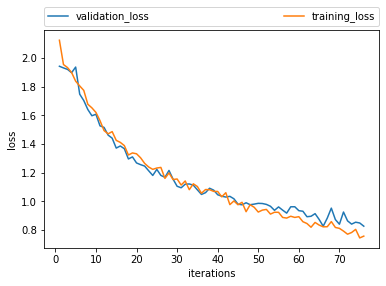

[1.9437755346298218,
 1.9322209400790078,
 1.921967544725963,
 1.8988248705863953,
 1.9381679466792516,
 1.7486716210842133,
 1.7044091011796678,
 1.6418275024209703,
 1.5982583846364702,
 1.6083991101809911,
 1.5275760293006897,
 1.5167271835463387,
 1.46315050976617,
 1.441545130951064,
 1.3723821256841933,
 1.3870568722486496,
 1.3680422689233507,
 1.2965364754199982,
 1.3108995045934404,
 1.268611416220665,
 1.2566974865538734,
 1.2467323413916997,
 1.2139037485633577,
 1.1813352299588067,
 1.223612632070269,
 1.1817387810775213,
 1.1682888780321394,
 1.2161574023110526,
 1.1556571956191743,
 1.1058230165924345,
 1.0952465874808175,
 1.1203128567763738,
 1.1219114065170288,
 1.1132185501711709,
 1.080662755029542,
 1.0487258498157774,
 1.0610817904983247,
 1.0919555936540877,
 1.0789181611367635,
 1.046640405697482,
 1.0364467395203454,
 1.0305135803563255,
 1.035401742373194,
 1.0182598339659827,
 0.9809842727013997,
 0.9764087391751153,
 0.9905906042882374,
 0.9769275869641986,
 

In [56]:
train_save('age', 4, 2)

minibatch:49, epoch:1, iteration:49, training_error:0.9085826683044433, validation_error:0.6828957707793625
Best loss improvement from inf to 0.6828957707793625 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.6868399393558502, validation_error:0.6806612367983218
Best loss improvement from 0.6828957707793625 to 0.6806612367983218 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:0.6580614542961121, validation_error:0.6539591043083756
Best loss improvement from 0.6806612367983218 to 0.6539591043083756 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:0.6494829893112183, validation_error:0.6297236305695993
Best loss improvement from 0.6539591043083756 to 0.6297236305695993 in epoch 1
minibatch:3, epoch:2, iteration:249, training_error:0.6097394347190856, validation_error:0.6257089332297996
Best loss improvement from 0.6297236305695993 to 0.6257089332297996 in epoch 2
minibatch:53, epoch:2, iteration:299, training_error:0.6415048837661743, val

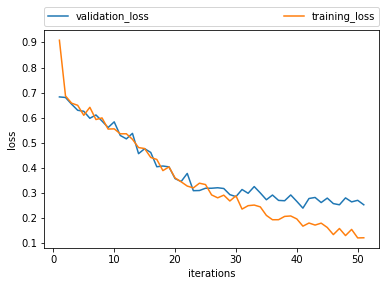

[0.6828957707793625,
 0.6806612367983218,
 0.6539591043083756,
 0.6297236305695993,
 0.6257089332297996,
 0.5978705397358647,
 0.6110597319073148,
 0.5867317561750058,
 0.5610807560108326,
 0.5835998323228624,
 0.5293740067217085,
 0.5158200021143313,
 0.5377552840444777,
 0.4568870023444847,
 0.4766958819495307,
 0.4618828230433994,
 0.40479619414718065,
 0.40775720057664094,
 0.40432973040474784,
 0.3575469415496897,
 0.3460033044770912,
 0.37826213240623474,
 0.3095441543393665,
 0.3101506757515448,
 0.31928406324651504,
 0.3192831989791658,
 0.32119444343778825,
 0.3181877643973739,
 0.29376021027565,
 0.28589663847729013,
 0.3142085083656841,
 0.299164272568844,
 0.32590122796871046,
 0.30052972998883987,
 0.27341667590317903,
 0.2921698104452204,
 0.2708270878151611,
 0.2694748960159443,
 0.29251996979669287,
 0.266869999744274,
 0.2400229603604034,
 0.27841447569705824,
 0.28254318706415316,
 0.262300885937832,
 0.28000527151204924,
 0.2580969728253506,
 0.2533848503673518,
 0.2

In [57]:
train_save('gender', 0, 0)

minibatch:49, epoch:1, iteration:49, training_error:0.9606858313083648, validation_error:0.7169334600711691
Best loss improvement from inf to 0.7169334600711691 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.6930775833129883, validation_error:0.6897893856311667
Best loss improvement from 0.7169334600711691 to 0.6897893856311667 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:0.684324107170105, validation_error:0.6929763956316586
minibatch:199, epoch:1, iteration:199, training_error:0.674258999824524, validation_error:0.6548100648255184
Best loss improvement from 0.6897893856311667 to 0.6548100648255184 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:0.6322051906585693, validation_error:0.6704511025856281
minibatch:47, epoch:2, iteration:299, training_error:0.6351882362365723, validation_error:0.6102575125365421
Best loss improvement from 0.6548100648255184 to 0.6102575125365421 in epoch 2
minibatch:97, epoch:2, iteration:349, training

minibatch:127, epoch:12, iteration:2899, training_error:0.09370608363300562, validation_error:0.27253771496230156
minibatch:177, epoch:12, iteration:2949, training_error:0.10692013163119554, validation_error:0.22422913205007028
minibatch:227, epoch:12, iteration:2999, training_error:0.1140458758175373, validation_error:0.2946994237537528
minibatch:25, epoch:13, iteration:3049, training_error:0.07502071658149362, validation_error:0.2793502424811495
minibatch:75, epoch:13, iteration:3099, training_error:0.059460197011940184, validation_error:0.3227624645906276
minibatch:125, epoch:13, iteration:3149, training_error:0.07957278565503657, validation_error:0.2838183717224105
minibatch:175, epoch:13, iteration:3199, training_error:0.07927234381437302, validation_error:0.30086904738483755
minibatch:225, epoch:13, iteration:3249, training_error:0.11349271804094314, validation_error:0.2921590431561244
Patience ran out at 3249. Ending training


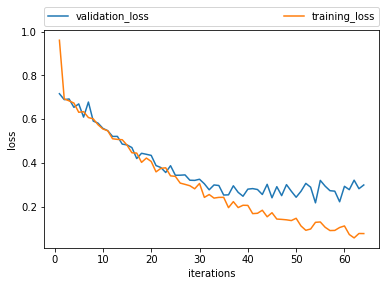

[0.7169334600711691,
 0.6897893856311667,
 0.6929763956316586,
 0.6548100648255184,
 0.6704511025856281,
 0.6102575125365421,
 0.6789439731630785,
 0.592222543625996,
 0.58263600180889,
 0.5589157250420801,
 0.5483103877511518,
 0.5220914072003858,
 0.5224859447314821,
 0.48717080005284014,
 0.4833937801163772,
 0.4714005538101854,
 0.42141779075408803,
 0.44530189037323,
 0.4406912388472721,
 0.43574507174820737,
 0.3892112549008994,
 0.38033282345738906,
 0.35773734350142805,
 0.38874219357967377,
 0.34511208688390665,
 0.3454286255713167,
 0.3467898492155404,
 0.3224981365532711,
 0.32172554320302504,
 0.32696854554373644,
 0.30631068400267897,
 0.2788198284547904,
 0.30099182704399374,
 0.29840711170229417,
 0.25501723150754796,
 0.25580276857162343,
 0.2971470206975937,
 0.2671876002488465,
 0.24946706151140147,
 0.2818373266992898,
 0.2843095444399735,
 0.2801154425431942,
 0.2574533799598957,
 0.3037927105765918,
 0.24238556058242403,
 0.29308483775319727,
 0.2522402660086237,
 

In [58]:
train_save('gender', 1, 0)

minibatch:49, epoch:1, iteration:49, training_error:0.9522752952575684, validation_error:0.7402870387866579
Best loss improvement from inf to 0.7402870387866579 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.696987988948822, validation_error:0.6806940744663107
Best loss improvement from 0.7402870387866579 to 0.6806940744663107 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:0.6823645377159119, validation_error:0.6476512058027859
Best loss improvement from 0.6806940744663107 to 0.6476512058027859 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:0.6603020000457763, validation_error:0.645811720141049
Best loss improvement from 0.6476512058027859 to 0.645811720141049 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:0.6388787341117859, validation_error:0.6541317475253138
minibatch:39, epoch:2, iteration:299, training_error:0.6200899457931519, validation_error:0.5947910177296606
Best loss improvement from 0.645811720141049 to

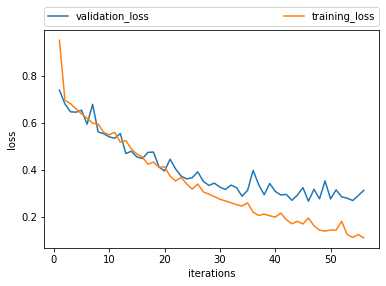

[0.7402870387866579,
 0.6806940744663107,
 0.6476512058027859,
 0.645811720141049,
 0.6541317475253138,
 0.5947910177296606,
 0.6793366629501869,
 0.5617963764174231,
 0.5544789988419105,
 0.5407851009533323,
 0.5348288457969139,
 0.5550199942342167,
 0.4699057268685308,
 0.4797013843881673,
 0.45535748683173083,
 0.4483794754949109,
 0.4748082037629752,
 0.47611362872452573,
 0.41229144560879677,
 0.3954259270224078,
 0.44557525268916426,
 0.403764343467252,
 0.37372424890255107,
 0.3617972957676855,
 0.36663779719122525,
 0.39184151744020396,
 0.3515240765851119,
 0.33408644692651157,
 0.34379097767944994,
 0.3266005541743903,
 0.3167231499121107,
 0.3354376867927354,
 0.3244015343230346,
 0.2881275595262133,
 0.31293351074744913,
 0.39794962262285166,
 0.33766749912294847,
 0.294280581176281,
 0.34219177170046444,
 0.30898494941407234,
 0.29338825828042525,
 0.2958218039109789,
 0.2704680330794433,
 0.29249256540989055,
 0.32459010132427873,
 0.2668586242301711,
 0.31769200697027405

In [59]:
train_save('gender', 2, 0)

minibatch:49, epoch:1, iteration:49, training_error:0.9741357052326203, validation_error:0.6976679214115801
Best loss improvement from inf to 0.6976679214115801 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.6990507936477661, validation_error:0.6993618258114519
minibatch:149, epoch:1, iteration:149, training_error:0.6918756806850433, validation_error:0.6776886047988102
Best loss improvement from 0.6976679214115801 to 0.6776886047988102 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:0.6690280032157898, validation_error:0.6423742216208885
Best loss improvement from 0.6776886047988102 to 0.6423742216208885 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:0.66413534283638, validation_error:0.6257011808198074
Best loss improvement from 0.6423742216208885 to 0.6257011808198074 in epoch 1
minibatch:41, epoch:2, iteration:299, training_error:0.6541910624504089, validation_error:0.6647531246316845
minibatch:91, epoch:2, iteration:349, training

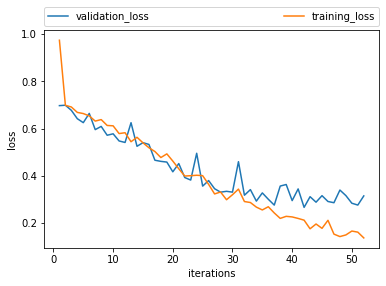

[0.6976679214115801,
 0.6993618258114519,
 0.6776886047988102,
 0.6423742216208885,
 0.6257011808198074,
 0.6647531246316845,
 0.5962582518314493,
 0.6097929416031673,
 0.5724518669062647,
 0.5785075909104841,
 0.5482608038803627,
 0.5419512041683855,
 0.6255105322804945,
 0.5257638620919195,
 0.5410401132600061,
 0.5336386910800276,
 0.46680708897524864,
 0.4620352079128397,
 0.4590134600113178,
 0.417878035841317,
 0.4527551182385149,
 0.393701434135437,
 0.3829773890561071,
 0.4962213522401349,
 0.35729800164699554,
 0.38086572135316915,
 0.3463576574777735,
 0.3317909985780716,
 0.3353902856851446,
 0.33189893950676097,
 0.4606676594964389,
 0.318839107607973,
 0.342560141251005,
 0.29394942573432264,
 0.3286020062093077,
 0.3018791701259284,
 0.2771265650617665,
 0.35762462585136806,
 0.3641699994432515,
 0.2961125068109611,
 0.34553203757466944,
 0.2675231759404314,
 0.3126116310214174,
 0.2894263968899332,
 0.31694029220219316,
 0.2923416479908187,
 0.28716879466484335,
 0.34073

In [60]:
train_save('gender', 3, 0)

minibatch:49, epoch:1, iteration:49, training_error:0.9539602816104888, validation_error:0.691833193959861
Best loss improvement from inf to 0.691833193959861 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.7130063140392303, validation_error:0.6917244010958178
Best loss improvement from 0.691833193959861 to 0.6917244010958178 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:0.6893182587623596, validation_error:0.670929569622566
Best loss improvement from 0.6917244010958178 to 0.670929569622566 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:0.6545333302021027, validation_error:0.6414580201280529
Best loss improvement from 0.670929569622566 to 0.6414580201280529 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:0.6324937462806701, validation_error:0.6136256384438482
Best loss improvement from 0.6414580201280529 to 0.6136256384438482 in epoch 1
minibatch:44, epoch:2, iteration:299, training_error:0.6233506721258163, validat

minibatch:44, epoch:12, iteration:2849, training_error:0.07590914130210877, validation_error:0.2789318191594091
minibatch:94, epoch:12, iteration:2899, training_error:0.08999565113335847, validation_error:0.28782020560626326
minibatch:144, epoch:12, iteration:2949, training_error:0.08507521983236074, validation_error:0.2853402238467644
minibatch:194, epoch:12, iteration:2999, training_error:0.11414083909243346, validation_error:0.27430539809424304
minibatch:244, epoch:12, iteration:3049, training_error:0.09861846465617419, validation_error:0.2525401184784955
minibatch:39, epoch:13, iteration:3099, training_error:0.06125516327098012, validation_error:0.27692505100677756
Patience ran out at 3099. Ending training


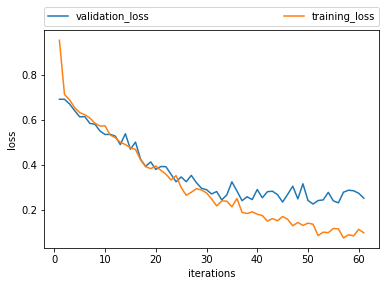

[0.691833193959861,
 0.6917244010958178,
 0.670929569622566,
 0.6414580201280529,
 0.6136256384438482,
 0.6148215429536228,
 0.5846235279379219,
 0.5810375336943001,
 0.5508408998620922,
 0.535206760825782,
 0.5360883124943437,
 0.5283426930164469,
 0.490336125266963,
 0.5387407222698475,
 0.46992054170575637,
 0.5014856056920414,
 0.4249498052843686,
 0.3938051898931635,
 0.4134851149443922,
 0.38022294023941305,
 0.39300559409733477,
 0.3923891459045739,
 0.3583533635427212,
 0.32534420747181464,
 0.34669782735150434,
 0.32537711591556157,
 0.3537352090251857,
 0.3214092270053666,
 0.2964472971085844,
 0.28990706852797804,
 0.27119954598361046,
 0.2820115487637191,
 0.24472575686101256,
 0.2668680610327885,
 0.32512044033099863,
 0.28424357417328605,
 0.24137118946889352,
 0.25873110623195256,
 0.24611033858924075,
 0.29087560315584315,
 0.2542004966787223,
 0.28122405656452837,
 0.2833048531721378,
 0.26787002692962514,
 0.23513461418192963,
 0.26972421438529576,
 0.3057661652565002

In [61]:
train_save('gender', 4, 0)

minibatch:49, epoch:1, iteration:49, training_error:0.9859773993492127, validation_error:0.7036866611904569
Best loss improvement from inf to 0.7036866611904569 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.694559315443039, validation_error:0.6806108134764212
Best loss improvement from 0.7036866611904569 to 0.6806108134764212 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:0.680615041255951, validation_error:0.642643963849103
Best loss improvement from 0.6806108134764212 to 0.642643963849103 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:0.6407324993610382, validation_error:0.6299476866368894
Best loss improvement from 0.642643963849103 to 0.6299476866368894 in epoch 1
minibatch:3, epoch:2, iteration:249, training_error:0.6454849886894226, validation_error:0.6178734059687014
Best loss improvement from 0.6299476866368894 to 0.6178734059687014 in epoch 2
minibatch:53, epoch:2, iteration:299, training_error:0.6196640491485595, validati

minibatch:143, epoch:12, iteration:2849, training_error:0.18052852779626846, validation_error:0.2610430803011965
minibatch:193, epoch:12, iteration:2899, training_error:0.17897414475679396, validation_error:0.2761705285973019
minibatch:243, epoch:12, iteration:2949, training_error:0.20114236049354076, validation_error:0.2683235078498169
minibatch:47, epoch:13, iteration:2999, training_error:0.16783227071166038, validation_error:0.301129678885142
minibatch:97, epoch:13, iteration:3049, training_error:0.20029646404087542, validation_error:0.25886510340151964
minibatch:147, epoch:13, iteration:3099, training_error:0.16112392745912074, validation_error:0.244814562300841
minibatch:197, epoch:13, iteration:3149, training_error:0.16932559333741665, validation_error:0.2582270492006231
minibatch:1, epoch:14, iteration:3199, training_error:0.19474635982885957, validation_error:0.27292058230550204
minibatch:51, epoch:14, iteration:3249, training_error:0.14303947985172272, validation_error:0.26104

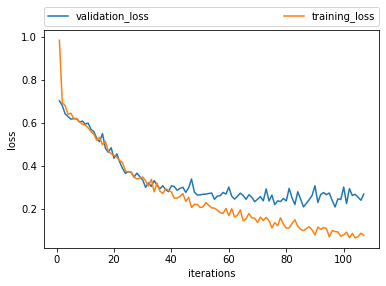

[0.7036866611904569,
 0.6806108134764212,
 0.642643963849103,
 0.6299476866368894,
 0.6178734059687014,
 0.6203482923684297,
 0.6194394120463619,
 0.60401216701225,
 0.6090452538596259,
 0.5942675140168932,
 0.5996622023759065,
 0.5695638259251913,
 0.5599444618931523,
 0.5269936102407949,
 0.5125670245400181,
 0.5506001799194901,
 0.4826353832527443,
 0.4631132262724417,
 0.4848241386590181,
 0.4358723925219642,
 0.45592232986732767,
 0.41823006117785416,
 0.3874517955161907,
 0.3648686541451348,
 0.37306460903750527,
 0.36929352747069466,
 0.3478452381160524,
 0.36604626918280564,
 0.3494975020488103,
 0.33448453192357663,
 0.29982684938995924,
 0.3209864061187815,
 0.30420880847507054,
 0.3312966674566269,
 0.30966610102741804,
 0.2936135249005424,
 0.30715762437493715,
 0.28868350441809054,
 0.2797933491291823,
 0.3068576962859542,
 0.30356273662160943,
 0.28622045064413987,
 0.29512391874083765,
 0.3002001775635613,
 0.27636744523489915,
 0.2975895857369458,
 0.33872024714946747,


In [62]:
train_save('gender', 0, 1)

minibatch:49, epoch:1, iteration:49, training_error:1.0925460529327393, validation_error:0.6995080133964275
Best loss improvement from inf to 0.6995080133964275 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.6938937437534333, validation_error:0.6906181471101169
Best loss improvement from 0.6995080133964275 to 0.6906181471101169 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:0.6939031755924225, validation_error:0.6953418234298969
minibatch:199, epoch:1, iteration:199, training_error:0.6980124282836914, validation_error:0.7071292071506895
minibatch:249, epoch:1, iteration:249, training_error:0.689230375289917, validation_error:0.6723717081135717
Best loss improvement from 0.6906181471101169 to 0.6723717081135717 in epoch 1
minibatch:47, epoch:2, iteration:299, training_error:0.6596841514110565, validation_error:0.6502198761907118
Best loss improvement from 0.6723717081135717 to 0.6502198761907118 in epoch 2
minibatch:97, epoch:2, iteration:349, trainin

minibatch:79, epoch:11, iteration:2599, training_error:0.19173773095011712, validation_error:0.2601267618351969
minibatch:129, epoch:11, iteration:2649, training_error:0.21012583538889884, validation_error:0.2849567845977586
minibatch:179, epoch:11, iteration:2699, training_error:0.21658934846520425, validation_error:0.25600452065981666
minibatch:229, epoch:11, iteration:2749, training_error:0.2011347008869052, validation_error:0.23252809869832006
Best loss improvement from 0.23514452705095554 to 0.23252809869832006 in epoch 11
minibatch:27, epoch:12, iteration:2799, training_error:0.18782606855034828, validation_error:0.2884205852089257
minibatch:77, epoch:12, iteration:2849, training_error:0.18338007889688016, validation_error:0.2552549603619966
minibatch:127, epoch:12, iteration:2899, training_error:0.21774182930588723, validation_error:0.25735202868436946
minibatch:177, epoch:12, iteration:2949, training_error:0.203021639585495, validation_error:0.23419283561665435
minibatch:227, e

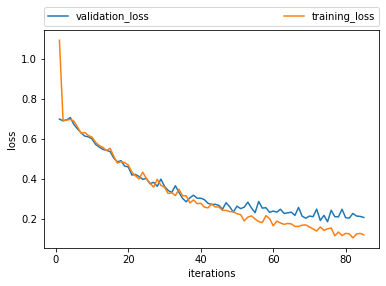

[0.6995080133964275,
 0.6906181471101169,
 0.6953418234298969,
 0.7071292071506895,
 0.6723717081135717,
 0.6502198761907118,
 0.6311084813085096,
 0.6144841025615561,
 0.6107750298648045,
 0.6000691734511276,
 0.5726490195455223,
 0.5600172548458494,
 0.5483429257212014,
 0.5435567683187025,
 0.5372493112909382,
 0.5052115023136139,
 0.48568424376948127,
 0.4920361607239164,
 0.4645778937586423,
 0.4609967290327467,
 0.42027802482761184,
 0.4230670558995214,
 0.41269743853601915,
 0.3989625768414859,
 0.40319287211730565,
 0.37661484089390984,
 0.3840790293340025,
 0.36375823616981506,
 0.39996635194482477,
 0.36348722977884884,
 0.3437276991276905,
 0.33335071853522596,
 0.36693477527848606,
 0.33429064627351435,
 0.3033859616723554,
 0.28682983563891773,
 0.3067425073220812,
 0.31964001419215365,
 0.3046317434516446,
 0.30482359410359944,
 0.29759780343236597,
 0.2794177634962674,
 0.2734901450317481,
 0.2743906810365874,
 0.26876321486357985,
 0.24967153922751031,
 0.28219876053004

In [63]:
train_save('gender', 1, 1)

minibatch:49, epoch:1, iteration:49, training_error:0.9876041781902313, validation_error:0.7287858868467396
Best loss improvement from inf to 0.7287858868467396 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.6965142071247101, validation_error:0.7057615045843453
Best loss improvement from 0.7287858868467396 to 0.7057615045843453 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:0.6905973339080811, validation_error:0.6664529668873754
Best loss improvement from 0.7057615045843453 to 0.6664529668873754 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:0.6555498766899109, validation_error:0.6388664800545265
Best loss improvement from 0.6664529668873754 to 0.6388664800545265 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:0.6440766644477844, validation_error:0.6195994574448158
Best loss improvement from 0.6388664800545265 to 0.6195994574448158 in epoch 1
minibatch:39, epoch:2, iteration:299, training_error:0.640671294927597, va

minibatch:199, epoch:11, iteration:2799, training_error:0.22950326174497604, validation_error:0.2713157786377545
Best loss improvement from 0.27595703483655537 to 0.2713157786377545 in epoch 11
minibatch:249, epoch:11, iteration:2849, training_error:0.18577735796570777, validation_error:0.28210188653962365
minibatch:39, epoch:12, iteration:2899, training_error:0.17064151540398598, validation_error:0.2998117645239008
minibatch:89, epoch:12, iteration:2949, training_error:0.18070428654551507, validation_error:0.28982684273144294
minibatch:139, epoch:12, iteration:2999, training_error:0.2021646586060524, validation_error:0.2610986178805088
Best loss improvement from 0.2713157786377545 to 0.2610986178805088 in epoch 12
minibatch:189, epoch:12, iteration:3049, training_error:0.19129835188388825, validation_error:0.26625411212444305
minibatch:239, epoch:12, iteration:3099, training_error:0.18432079784572125, validation_error:0.28132658040729064
minibatch:29, epoch:13, iteration:3149, trainin

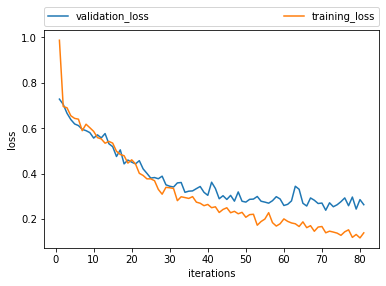

[0.7287858868467396,
 0.7057615045843453,
 0.6664529668873754,
 0.6388664800545265,
 0.6195994574448158,
 0.6124123355437969,
 0.5959710458229328,
 0.5901174041731604,
 0.5814297486995829,
 0.5575453248517267,
 0.571664991049931,
 0.5582339332021516,
 0.5773746124629316,
 0.5327072657387832,
 0.5198141737230892,
 0.4764706615743966,
 0.5056829401131334,
 0.44397997034007103,
 0.4610167628732221,
 0.4516090678757635,
 0.44413034360984277,
 0.458146635828347,
 0.4221046443643241,
 0.4023471490062516,
 0.38167597250691776,
 0.38400447368621826,
 0.378721016234365,
 0.3900201027763301,
 0.3519811429854097,
 0.34579879199636393,
 0.342340211416113,
 0.3603425457559783,
 0.36224835340319006,
 0.3189823668578575,
 0.3240766345426954,
 0.32523517567535926,
 0.3352428535962927,
 0.3446494983188037,
 0.31901431751662285,
 0.3057568710425804,
 0.36345336355012037,
 0.33581551395613574,
 0.29076665485727377,
 0.3040606073778251,
 0.2876673353643253,
 0.30547739925055667,
 0.28017366600447685,
 0.3

In [64]:
train_save('gender', 2, 1)

minibatch:49, epoch:1, iteration:49, training_error:0.9176038980484009, validation_error:0.6926721293350746
Best loss improvement from inf to 0.6926721293350746 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.6983117973804474, validation_error:0.6799434813959845
Best loss improvement from 0.6926721293350746 to 0.6799434813959845 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:0.6791663980484008, validation_error:0.6677901744842529
Best loss improvement from 0.6799434813959845 to 0.6677901744842529 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:0.6708913922309876, validation_error:0.6454819995781471
Best loss improvement from 0.6677901744842529 to 0.6454819995781471 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:0.6551919436454773, validation_error:0.6278790461605993
Best loss improvement from 0.6454819995781471 to 0.6278790461605993 in epoch 1
minibatch:41, epoch:2, iteration:299, training_error:0.650238538980484, va

minibatch:11, epoch:12, iteration:2849, training_error:0.20235188871622087, validation_error:0.2897564424522992
minibatch:61, epoch:12, iteration:2899, training_error:0.2272251744568348, validation_error:0.273841324037519
minibatch:111, epoch:12, iteration:2949, training_error:0.17181486114859582, validation_error:0.2672394806968755
minibatch:161, epoch:12, iteration:2999, training_error:0.1959023241698742, validation_error:0.2519639730453491
Best loss improvement from 0.25476168609898664 to 0.2519639730453491 in epoch 12
minibatch:211, epoch:12, iteration:3049, training_error:0.16515450961887837, validation_error:0.25308334544814864
minibatch:3, epoch:13, iteration:3099, training_error:0.1661051681637764, validation_error:0.24168086976840578
Best loss improvement from 0.2519639730453491 to 0.24168086976840578 in epoch 13
minibatch:53, epoch:13, iteration:3149, training_error:0.1432204932719469, validation_error:0.27062299847602844
minibatch:103, epoch:13, iteration:3199, training_erro

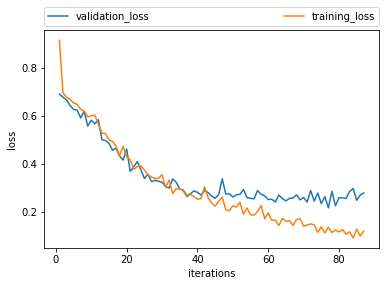

[0.6926721293350746,
 0.6799434813959845,
 0.6677901744842529,
 0.6454819995781471,
 0.6278790461605993,
 0.6265197170191797,
 0.5928428728004982,
 0.6208097092036543,
 0.5591081637760689,
 0.5832619985629772,
 0.5680106652194056,
 0.5853853821754456,
 0.502682399133156,
 0.49794305604079675,
 0.48729690703852424,
 0.45797228093804987,
 0.466573449044392,
 0.43353584922593214,
 0.4169572725378234,
 0.46285225194076013,
 0.3699303033023045,
 0.38800742657020176,
 0.4109252614193949,
 0.3766552775070585,
 0.3397733599975191,
 0.3577640226175045,
 0.32715983020848244,
 0.33193772363251656,
 0.32844229864663094,
 0.324452210089256,
 0.30621771565799055,
 0.3001876812556694,
 0.33809274332276706,
 0.3237636089324951,
 0.2965703020835745,
 0.29124919916021413,
 0.267956899671719,
 0.27567094307521295,
 0.2879217205376461,
 0.2822921522732439,
 0.27057460027522057,
 0.28894433225023336,
 0.28097198595260753,
 0.2659946582440672,
 0.25751536570746325,
 0.27262254727297813,
 0.33832636886629563

In [65]:
train_save('gender', 3, 1)

minibatch:49, epoch:1, iteration:49, training_error:0.956522890329361, validation_error:0.7557612287587133
Best loss improvement from inf to 0.7557612287587133 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.7043420016765595, validation_error:0.6956858614395405
Best loss improvement from 0.7557612287587133 to 0.6956858614395405 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:0.7076768922805786, validation_error:0.6739743043636454
Best loss improvement from 0.6956858614395405 to 0.6739743043636454 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:0.6473053801059723, validation_error:0.6338773657535685
Best loss improvement from 0.6739743043636454 to 0.6338773657535685 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:0.6342507314682007, validation_error:0.6140100955963135
Best loss improvement from 0.6338773657535685 to 0.6140100955963135 in epoch 1
minibatch:44, epoch:2, iteration:299, training_error:0.6321857559680939, va

minibatch:99, epoch:11, iteration:2649, training_error:0.19249616079032422, validation_error:0.25950497440223036
minibatch:149, epoch:11, iteration:2699, training_error:0.1576473367959261, validation_error:0.24829482852384963
minibatch:199, epoch:11, iteration:2749, training_error:0.16531030908226968, validation_error:0.25908565264323663
minibatch:249, epoch:11, iteration:2799, training_error:0.17192066118121146, validation_error:0.24833792807727023
minibatch:44, epoch:12, iteration:2849, training_error:0.15491953689604998, validation_error:0.23020546600736422
minibatch:94, epoch:12, iteration:2899, training_error:0.16464952684938908, validation_error:0.20686778528936978
minibatch:144, epoch:12, iteration:2949, training_error:0.16027463011443616, validation_error:0.20844026937566953
Patience ran out at 2949. Ending training


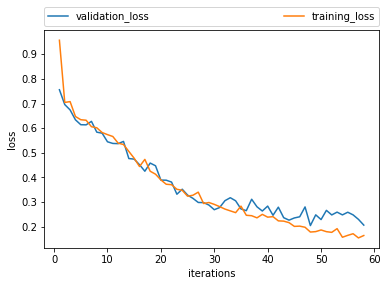

[0.7557612287587133,
 0.6956858614395405,
 0.6739743043636454,
 0.6338773657535685,
 0.6140100955963135,
 0.6134520892439217,
 0.6275844162908094,
 0.5837317355747881,
 0.5796541962130316,
 0.5447937743417148,
 0.5380604482930282,
 0.537171131577985,
 0.5462298269929557,
 0.4767902236560295,
 0.474499608935981,
 0.45189320527274035,
 0.42536902633206597,
 0.45846010795955,
 0.4474568983604168,
 0.3894149599404171,
 0.38900492571551226,
 0.3813397062235865,
 0.3320742092769721,
 0.35238102181204434,
 0.3286214964143161,
 0.315440375229408,
 0.2987061430668009,
 0.2981019739446969,
 0.28819192843190555,
 0.26929713785648346,
 0.2780520134958728,
 0.3058986406901787,
 0.31795269661936265,
 0.30546088105645675,
 0.2724854997519789,
 0.26541468758007575,
 0.3117858649327837,
 0.28108036775013495,
 0.26400390935355217,
 0.283924699343484,
 0.2467430051544617,
 0.2796326531418439,
 0.2369888943844828,
 0.2269549105187942,
 0.2359118903505391,
 0.24062521755695343,
 0.28062778557169027,
 0.204

In [66]:
train_save('gender', 4, 1)

minibatch:49, epoch:1, iteration:49, training_error:0.9781802690029144, validation_error:0.6993294093343947
Best loss improvement from inf to 0.6993294093343947 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.6993657231330872, validation_error:0.7095594891795406
minibatch:149, epoch:1, iteration:149, training_error:0.6963032591342926, validation_error:0.6807277202606201
Best loss improvement from 0.6993294093343947 to 0.6807277202606201 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:0.6780674195289612, validation_error:0.6578652174384506
Best loss improvement from 0.6807277202606201 to 0.6578652174384506 in epoch 1
minibatch:3, epoch:2, iteration:249, training_error:0.657898542881012, validation_error:0.6961279290693777
minibatch:53, epoch:2, iteration:299, training_error:0.6505890572071076, validation_error:0.6362321928695396
Best loss improvement from 0.6578652174384506 to 0.6362321928695396 in epoch 2
minibatch:103, epoch:2, iteration:349, training

minibatch:43, epoch:12, iteration:2749, training_error:0.24946982860565187, validation_error:0.2764902655725126
minibatch:93, epoch:12, iteration:2799, training_error:0.24703280329704286, validation_error:0.28217178527955655
minibatch:143, epoch:12, iteration:2849, training_error:0.2323784723877907, validation_error:0.267376943870827
minibatch:193, epoch:12, iteration:2899, training_error:0.23374158322811125, validation_error:0.2554963462882572
Best loss improvement from 0.26402155503078745 to 0.2554963462882572 in epoch 12
minibatch:243, epoch:12, iteration:2949, training_error:0.23892954111099243, validation_error:0.2801694875514066
minibatch:47, epoch:13, iteration:2999, training_error:0.2240074786916375, validation_error:0.28339648964228453
minibatch:97, epoch:13, iteration:3049, training_error:0.25020664095878603, validation_error:0.24206658645912452
Best loss improvement from 0.2554963462882572 to 0.24206658645912452 in epoch 13
minibatch:147, epoch:13, iteration:3099, training_e

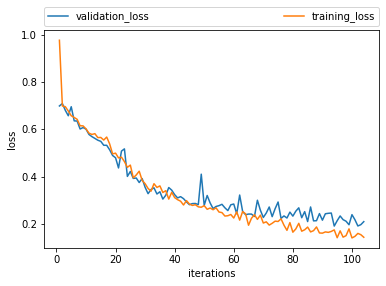

[0.6993294093343947,
 0.7095594891795406,
 0.6807277202606201,
 0.6578652174384506,
 0.6961279290693777,
 0.6362321928695396,
 0.6353720371369962,
 0.6016001303990682,
 0.6077394397170456,
 0.6011404814543547,
 0.5784939913837998,
 0.5692610012160407,
 0.5617614101480555,
 0.554099734182711,
 0.5492611604708212,
 0.5326377959163101,
 0.5325313674079047,
 0.5134569682456829,
 0.4893154071436988,
 0.47952888630054613,
 0.43642422556877136,
 0.5079213193169346,
 0.5173825621604919,
 0.4005472781481566,
 0.4214683009518517,
 0.3920396936160547,
 0.39374754715848853,
 0.3745799108787819,
 0.3911994320374948,
 0.3543859256638421,
 0.3272599263323678,
 0.3448250503451736,
 0.35221104434242956,
 0.3259177097567805,
 0.3354594337719458,
 0.3042545489690922,
 0.3206154621309704,
 0.3533071113957299,
 0.3423108188090501,
 0.3229936515843427,
 0.3093630654944314,
 0.3146990289290746,
 0.30615430959948786,
 0.29239990203468885,
 0.280635886170246,
 0.2852587037616306,
 0.28572141710254884,
 0.28077

In [67]:
train_save('gender', 0, 2)

minibatch:49, epoch:1, iteration:49, training_error:0.9719089686870575, validation_error:0.7062959259953993
Best loss improvement from inf to 0.7062959259953993 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.7017213129997253, validation_error:0.6983098572698133
Best loss improvement from 0.7062959259953993 to 0.6983098572698133 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:0.6962667429447174, validation_error:0.687722189673062
Best loss improvement from 0.6983098572698133 to 0.687722189673062 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:0.686371420621872, validation_error:0.697729780756194
minibatch:249, epoch:1, iteration:249, training_error:0.6649737870693206, validation_error:0.6446039060066486
Best loss improvement from 0.687722189673062 to 0.6446039060066486 in epoch 1
minibatch:47, epoch:2, iteration:299, training_error:0.6507097911834717, validation_error:0.6296188111962944
Best loss improvement from 0.6446039060066486 to 

minibatch:27, epoch:12, iteration:2799, training_error:0.23324165850877762, validation_error:0.23853364239992766
minibatch:77, epoch:12, iteration:2849, training_error:0.21314635425806044, validation_error:0.23552712438435391
minibatch:127, epoch:12, iteration:2899, training_error:0.20885462626814844, validation_error:0.2336795455936728
Best loss improvement from 0.2349287602922012 to 0.2336795455936728 in epoch 12
minibatch:177, epoch:12, iteration:2949, training_error:0.23070133730769157, validation_error:0.23026863254349808
Best loss improvement from 0.2336795455936728 to 0.23026863254349808 in epoch 12
minibatch:227, epoch:12, iteration:2999, training_error:0.24600280374288558, validation_error:0.2485220730304718
minibatch:25, epoch:13, iteration:3049, training_error:0.21288214787840842, validation_error:0.2250070109449584
Best loss improvement from 0.23026863254349808 to 0.2250070109449584 in epoch 13
minibatch:75, epoch:13, iteration:3099, training_error:0.22860903918743133, vali

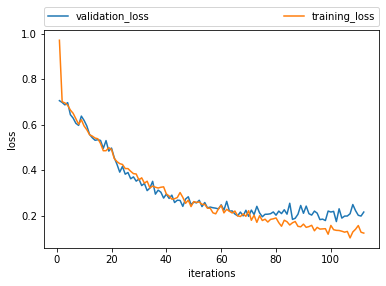

[0.7062959259953993,
 0.6983098572698133,
 0.687722189673062,
 0.697729780756194,
 0.6446039060066486,
 0.6296188111962944,
 0.6067135590931465,
 0.5975699136997091,
 0.6384498322832173,
 0.6192920804023743,
 0.5948426877630169,
 0.5578097855222637,
 0.5431204941766016,
 0.5321502315587011,
 0.5344856237543041,
 0.531520209435759,
 0.4965185471649828,
 0.5307670687807018,
 0.4845071948807815,
 0.49797470919017134,
 0.4555581797813547,
 0.42621250193694543,
 0.3920936241489032,
 0.41716892657608823,
 0.3830349322023063,
 0.3905784220531069,
 0.36286327345617886,
 0.3712393173883701,
 0.35246559515081605,
 0.3617037385702133,
 0.333043180149177,
 0.34214299897952327,
 0.31082955568001186,
 0.3222923602523475,
 0.3517617372603252,
 0.2952692637155796,
 0.3129106410618486,
 0.3038076856013002,
 0.2780697787630147,
 0.29548852608121673,
 0.2765618674778219,
 0.29093592279943925,
 0.25844896019532765,
 0.26862944919487525,
 0.26781631877710077,
 0.2415240892562373,
 0.2737829161101374,
 0.28

In [68]:
train_save('gender', 1, 2)

minibatch:49, epoch:1, iteration:49, training_error:0.9537362599372864, validation_error:0.7001969690980583
Best loss improvement from inf to 0.7001969690980583 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.6935555517673493, validation_error:0.690790174336269
Best loss improvement from 0.7001969690980583 to 0.690790174336269 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:0.6830906701087952, validation_error:0.6622000439413662
Best loss improvement from 0.690790174336269 to 0.6622000439413662 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:0.6547329318523407, validation_error:0.63764947036217
Best loss improvement from 0.6622000439413662 to 0.63764947036217 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:0.6372693157196045, validation_error:0.6203193459017523
Best loss improvement from 0.63764947036217 to 0.6203193459017523 in epoch 1
minibatch:39, epoch:2, iteration:299, training_error:0.6363610124588013, validation

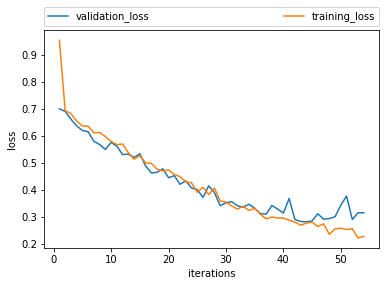

[0.7001969690980583,
 0.690790174336269,
 0.6622000439413662,
 0.63764947036217,
 0.6203193459017523,
 0.6159500664678114,
 0.5804490292894429,
 0.5686453005363201,
 0.5504482768732926,
 0.5761224935794699,
 0.5623803693672706,
 0.5314202801934604,
 0.5329574110179112,
 0.5208045583346794,
 0.5346108233106548,
 0.4898727556754803,
 0.4634917738108799,
 0.4658035471521575,
 0.4788894971896862,
 0.4460710718713958,
 0.4534743674870195,
 0.4217439232201412,
 0.4339536716198099,
 0.4079558479374853,
 0.40201570453314944,
 0.3731415693102212,
 0.41589037097733594,
 0.3907447025693696,
 0.34212871306929094,
 0.35326658343446665,
 0.3571928410694517,
 0.3423076929717228,
 0.3370892179423365,
 0.3480435137091012,
 0.3331187588387522,
 0.3132494004635975,
 0.31136396681440287,
 0.34322105656410085,
 0.32999012388032056,
 0.3153562797554608,
 0.36901670437434625,
 0.29182536643126916,
 0.28420980839893734,
 0.2827921072984564,
 0.286448974547715,
 0.31273761828397884,
 0.2925830863673112,
 0.295

In [69]:
train_save('gender', 2, 2)

minibatch:49, epoch:1, iteration:49, training_error:0.9667547369003295, validation_error:0.7041806126463002
Best loss improvement from inf to 0.7041806126463002 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.7049080204963684, validation_error:0.6876614730933617
Best loss improvement from 0.7041806126463002 to 0.6876614730933617 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:0.6898165571689606, validation_error:0.675972829604971
Best loss improvement from 0.6876614730933617 to 0.675972829604971 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:0.6728968274593353, validation_error:0.6725086384806139
Best loss improvement from 0.675972829604971 to 0.6725086384806139 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:0.6552113163471222, validation_error:0.6889816728131525
minibatch:41, epoch:2, iteration:299, training_error:0.6602077400684356, validation_error:0.6119415328420442
Best loss improvement from 0.6725086384806139 t

minibatch:61, epoch:12, iteration:2899, training_error:0.24768162220716478, validation_error:0.3061433984287854
minibatch:111, epoch:12, iteration:2949, training_error:0.23035978510975838, validation_error:0.24925142989076418
Best loss improvement from 0.252565523159915 to 0.24925142989076418 in epoch 12
minibatch:161, epoch:12, iteration:2999, training_error:0.23039169162511824, validation_error:0.23920429215349
Best loss improvement from 0.24925142989076418 to 0.23920429215349 in epoch 12
minibatch:211, epoch:12, iteration:3049, training_error:0.22214909702539443, validation_error:0.2701835575802573
minibatch:3, epoch:13, iteration:3099, training_error:0.21132326336577534, validation_error:0.2674325877993271
minibatch:53, epoch:13, iteration:3149, training_error:0.21061656028032302, validation_error:0.25324310670638905
minibatch:103, epoch:13, iteration:3199, training_error:0.213398969322443, validation_error:0.26414289119942436
minibatch:153, epoch:13, iteration:3249, training_error

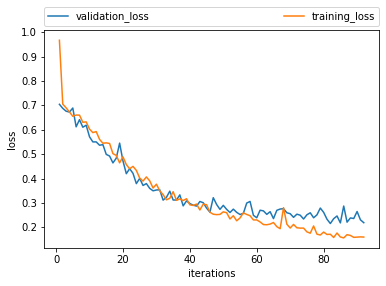

[0.7041806126463002,
 0.6876614730933617,
 0.675972829604971,
 0.6725086384806139,
 0.6889816728131525,
 0.6119415328420442,
 0.6412318965484356,
 0.6102689319643481,
 0.6185485021821384,
 0.5710331417363266,
 0.5500689642182712,
 0.5502016441575412,
 0.5364975682620344,
 0.5389328115972979,
 0.4989994373814813,
 0.49218487122963217,
 0.46398559520984517,
 0.4834777548395354,
 0.5451143281213169,
 0.4720734779177041,
 0.41988117941494646,
 0.44041188420920535,
 0.42124341890729705,
 0.37917286979741066,
 0.4005493516552037,
 0.3716951182176327,
 0.3793079236458088,
 0.35968893715019884,
 0.3496846911208383,
 0.3530344171770688,
 0.35384715528323735,
 0.31143198804608707,
 0.3231657764007305,
 0.3482735023416322,
 0.31198806033052245,
 0.3119849752763222,
 0.3329964901866584,
 0.28801534710259274,
 0.3083746058159861,
 0.2973967256217167,
 0.290900230921548,
 0.28708965973607425,
 0.3059329544675761,
 0.3008940456242397,
 0.27886184638944167,
 0.262242043326641,
 0.32151084162037946,
 0

In [70]:
train_save('gender', 3, 2)

minibatch:49, epoch:1, iteration:49, training_error:0.9684971117973328, validation_error:0.6955722262119425
Best loss improvement from inf to 0.6955722262119425 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.7038715291023254, validation_error:0.7044664847439733
minibatch:149, epoch:1, iteration:149, training_error:0.6898585426807403, validation_error:0.6754352018750948
Best loss improvement from 0.6955722262119425 to 0.6754352018750948 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:0.6708744192123413, validation_error:0.6434537788917278
Best loss improvement from 0.6754352018750948 to 0.6434537788917278 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:0.6465671503543854, validation_error:0.6132660158749285
Best loss improvement from 0.6434537788917278 to 0.6132660158749285 in epoch 1
minibatch:44, epoch:2, iteration:299, training_error:0.6177815294265747, validation_error:0.6170164911911405
minibatch:94, epoch:2, iteration:349, traini

minibatch:94, epoch:12, iteration:2899, training_error:0.2110931958258152, validation_error:0.24298973689819203
minibatch:144, epoch:12, iteration:2949, training_error:0.2247852775454521, validation_error:0.22903248372262922
minibatch:194, epoch:12, iteration:2999, training_error:0.19972721189260484, validation_error:0.23455227628864092
minibatch:244, epoch:12, iteration:3049, training_error:0.2005664612352848, validation_error:0.2098827718532291
Best loss improvement from 0.2252971987272131 to 0.2098827718532291 in epoch 12
minibatch:39, epoch:13, iteration:3099, training_error:0.18750885233283043, validation_error:0.2645068094134331
minibatch:89, epoch:13, iteration:3149, training_error:0.20697980582714082, validation_error:0.24024217524405184
minibatch:139, epoch:13, iteration:3199, training_error:0.19196692809462548, validation_error:0.21439094083576365
minibatch:189, epoch:13, iteration:3249, training_error:0.19180042997002603, validation_error:0.2130106022131854
minibatch:239, ep

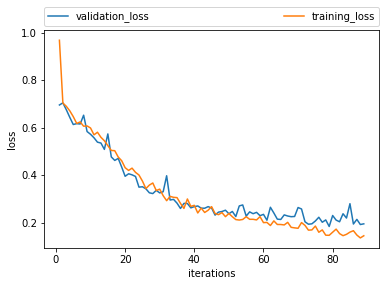

[0.6955722262119425,
 0.7044664847439733,
 0.6754352018750948,
 0.6434537788917278,
 0.6132660158749285,
 0.6170164911911405,
 0.6154748859076664,
 0.65253504185841,
 0.5836140009863623,
 0.5720707856375595,
 0.557299163834802,
 0.5388698526497545,
 0.5352296931990261,
 0.5084081066065821,
 0.573601011572213,
 0.4766848364780689,
 0.4618930323370572,
 0.47044372969660264,
 0.43411183562772027,
 0.39501223481934644,
 0.4056062873067527,
 0.4011971950531006,
 0.394321549555351,
 0.3492552221849047,
 0.3508928916577635,
 0.34226926441850336,
 0.32548167582215937,
 0.3221080046275566,
 0.3357158025790905,
 0.32498826497587663,
 0.3299176924187562,
 0.39730158859285813,
 0.2950196147992693,
 0.2977474871380576,
 0.2818204524188206,
 0.2594379037618637,
 0.28085143966921444,
 0.28042050939181756,
 0.2620056816216173,
 0.26709727223577173,
 0.27001074213406134,
 0.2606414957293149,
 0.26041004344307145,
 0.26714279785238465,
 0.2612930094373637,
 0.23139838000823712,
 0.24399613691815014,
 0.

In [71]:
train_save('gender', 4, 2)

In [72]:
print(get_performance_of_a_model("test", "gender", 0, 0))
print(get_performance_of_a_model("test", "gender", 1, 0))
print(get_performance_of_a_model("test", "gender", 2, 0))
print(get_performance_of_a_model("test", "gender", 3, 0))
print(get_performance_of_a_model("test", "gender", 4, 0))

{'accuracy': 0.836785625155977}
{'accuracy': 0.8148454746136865}
{'accuracy': 0.8326543403321842}
{'accuracy': 0.8447860156720917}
{'accuracy': 0.8079699682356338}


In [73]:
print(get_performance_of_a_model("test", "gender", 0, 1))
print(get_performance_of_a_model("test", "gender", 1, 1))
print(get_performance_of_a_model("test", "gender", 2, 1))
print(get_performance_of_a_model("test", "gender", 3, 1))
print(get_performance_of_a_model("test", "gender", 4, 1))

{'accuracy': 0.8532568005989518}
{'accuracy': 0.8338852097130243}
{'accuracy': 0.8473832654340332}
{'accuracy': 0.8652802893309223}
{'accuracy': 0.8235633843488305}


In [74]:
print(get_performance_of_a_model("test", "gender", 0, 2))
print(get_performance_of_a_model("test", "gender", 1, 2))
print(get_performance_of_a_model("test", "gender", 2, 2))
print(get_performance_of_a_model("test", "gender", 3, 2))
print(get_performance_of_a_model("test", "gender", 4, 2))

{'accuracy': 0.8704766658347891}
{'accuracy': 0.8606512141280354}
{'accuracy': 0.829520526480727}
{'accuracy': 0.8761301989150091}
{'accuracy': 0.8284724227548369}


In [75]:
print(get_performance_of_a_model("test", "age", 0, 0))
print(get_performance_of_a_model("test", "age", 1, 0))
print(get_performance_of_a_model("test", "age", 2, 0))
print(get_performance_of_a_model("test", "age", 3, 0))
print(get_performance_of_a_model("test", "age", 4, 0))

{'accuracy': 0.5373030583873958, 'one-off accuracy': 0.8345690454124189}
{'accuracy': 0.4166397936149629, 'one-off accuracy': 0.8052241212512092}
{'accuracy': 0.5354896675651393, 'one-off accuracy': 0.8580413297394429}
{'accuracy': 0.4830252100840336, 'one-off accuracy': 0.8094117647058824}
{'accuracy': 0.4833468724614135, 'one-off accuracy': 0.793392905496886}


In [76]:
print(get_performance_of_a_model("test", "age", 0, 1))
print(get_performance_of_a_model("test", "age", 1, 1))
print(get_performance_of_a_model("test", "age", 2, 1))
print(get_performance_of_a_model("test", "age", 3, 1))
print(get_performance_of_a_model("test", "age", 4, 1))

{'accuracy': 0.5563021316033364, 'one-off accuracy': 0.8816033364226136}
{'accuracy': 0.418574653337633, 'one-off accuracy': 0.8223153821347953}
{'accuracy': 0.5633423180592992, 'one-off accuracy': 0.8703204552261156}
{'accuracy': 0.4672268907563025, 'one-off accuracy': 0.852436974789916}
{'accuracy': 0.5014893040888166, 'one-off accuracy': 0.8193880314107771}


In [77]:
print(get_performance_of_a_model("test", "age", 0, 2))
print(get_performance_of_a_model("test", "age", 1, 2))
print(get_performance_of_a_model("test", "age", 2, 2))
print(get_performance_of_a_model("test", "age", 3, 2))
print(get_performance_of_a_model("test", "age", 4, 2))

{'accuracy': 0.590129749768304, 'one-off accuracy': 0.8959684893419834}
{'accuracy': 0.4450177362141245, 'one-off accuracy': 0.8481135117703966}
{'accuracy': 0.5729260257562144, 'one-off accuracy': 0.8873914345612459}
{'accuracy': 0.46521008403361347, 'one-off accuracy': 0.8389915966386554}
{'accuracy': 0.49553208773354995, 'one-off accuracy': 0.8147847278635256}


In [78]:
print(get_performance_of_a_model("test", "both", 0, 0))
print(get_performance_of_a_model("test", "both", 1, 0))
print(get_performance_of_a_model("test", "both", 2, 0))
print(get_performance_of_a_model("test", "both", 3, 0))
print(get_performance_of_a_model("test", "both", 4, 0))

{'accuracy': 0.45372518690384117, 'one-off accuracy': 0.7437483887599897, 'gender accuracy': 0.8453209590100541, 'age accuracy': 0.45810775973188966, 'one-off age accuracy': 0.7594740912606341}
{'accuracy': 0.34442595673876875, 'one-off accuracy': 0.6871880199667221, 'gender accuracy': 0.8239600665557404, 'age accuracy': 0.3520798668885191, 'one-off age accuracy': 0.7108153078202994}
{'accuracy': 0.4043575776994553, 'one-off accuracy': 0.6943287407882089, 'gender accuracy': 0.81256007689843, 'age accuracy': 0.40820249919897467, 'one-off age accuracy': 0.7154758090355655}
{'accuracy': 0.3628750872295883, 'one-off accuracy': 0.6950453593859037, 'gender accuracy': 0.8391486392184229, 'age accuracy': 0.36461967899511516, 'one-off age accuracy': 0.7048150732728542}
{'accuracy': 0.30558015943312666, 'one-off accuracy': 0.6220844405078241, 'gender accuracy': 0.7921464422793032, 'age accuracy': 0.3073516386182462, 'one-off age accuracy': 0.6380277531739003}


In [79]:
print(get_performance_of_a_model("test", "both", 0, 1))
print(get_performance_of_a_model("test", "both", 1, 1))
print(get_performance_of_a_model("test", "both", 2, 1))
print(get_performance_of_a_model("test", "both", 3, 1))
print(get_performance_of_a_model("test", "both", 4, 1))

{'accuracy': 0.42665635473060065, 'one-off accuracy': 0.7478731631863882, 'gender accuracy': 0.8463521526166538, 'age accuracy': 0.42871874194379994, 'one-off age accuracy': 0.7661768497035318}
{'accuracy': 0.3454242928452579, 'one-off accuracy': 0.6925124792013311, 'gender accuracy': 0.8116472545757072, 'age accuracy': 0.351414309484193, 'one-off age accuracy': 0.7071547420965059}
{'accuracy': 0.4296699775712913, 'one-off accuracy': 0.725088112784364, 'gender accuracy': 0.818647869272669, 'age accuracy': 0.43383530919577057, 'one-off age accuracy': 0.7404677987824415}
{'accuracy': 0.3834612700628053, 'one-off accuracy': 0.7229588276343336, 'gender accuracy': 0.8513607815771109, 'age accuracy': 0.3866015352407537, 'one-off age accuracy': 0.7337752965806001}
{'accuracy': 0.33480956598759964, 'one-off accuracy': 0.6454089164452318, 'gender accuracy': 0.7992323590197815, 'age accuracy': 0.3359905521110127, 'one-off age accuracy': 0.6572187776793623}


In [80]:
print(get_performance_of_a_model("test", "both", 0, 2))
print(get_performance_of_a_model("test", "both", 1, 2))
print(get_performance_of_a_model("test", "both", 2, 2))
print(get_performance_of_a_model("test", "both", 3, 2))
print(get_performance_of_a_model("test", "both", 4, 2))

{'accuracy': 0.4462490332559938, 'one-off accuracy': 0.7754575921629286, 'gender accuracy': 0.8682650167568962, 'age accuracy': 0.4511472028873421, 'one-off age accuracy': 0.7839649394173757}
{'accuracy': 0.3653910149750416, 'one-off accuracy': 0.7261231281198003, 'gender accuracy': 0.83261231281198, 'age accuracy': 0.36905158069883526, 'one-off age accuracy': 0.7384359400998336}
{'accuracy': 0.4601089394424864, 'one-off accuracy': 0.7574495354053188, 'gender accuracy': 0.8551746235181031, 'age accuracy': 0.46491509131688563, 'one-off age accuracy': 0.7670618391541173}
{'accuracy': 0.40369853454291693, 'one-off accuracy': 0.7515701325889742, 'gender accuracy': 0.8628750872295883, 'age accuracy': 0.4061409630146546, 'one-off age accuracy': 0.7581995812979763}
{'accuracy': 0.3563625627398878, 'one-off accuracy': 0.6643046944198405, 'gender accuracy': 0.8160614112784175, 'age accuracy': 0.35783879539415414, 'one-off age accuracy': 0.6767050487156776}


### How to run?

1.   **Run `train_save()`:**


> You can do this for different combinations of **`c`**, **`fold`**, and **`train_transform_index`**, where **`c={'age','gender'}`**, **`fold={0,1,2,3,4}`**, and **`train_transform_index={0,1,2}`**.

> I suggest you to first train the network on all the folds for **either** **`age`** or **`gender`** and then proceed to the setp 2. Then, follow the same steps for the other class. Also, use **`train_transform_index=2`** as it gives smaller validation error due to random flipping and cropping.

> **Note:** It is just the network's architecture that is the same for age and gender. They both are trained independently. Ultimately, we will be having two different networks with the same architecture, one to classify age and the other to classify gender.

2. **Picking the best model:**

> Call **`pick_best_model()`** on either **`age`** or **`gender`**.

3. **Know the performance:**

> Call **`get_performance()`** on either **`age`** or **`gender`** to know the final performance of the network on the test set.



